In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Set two decimal points for display
pd.options.display.float_format = "{:.2f}".format

# Load the Data

In [4]:
import pyreadstat
uds, meta = pyreadstat.read_sas7bdat("C:/Users/tsb7592/Downloads/armada_uds_sep21_di.sas7bdat")
uds.shape

(1046, 652)

In [5]:
marital ={1:"Married", 2:"Widowed", 3:"Divorced",
4:"Separated", 5:"Never married (or marriage was annulled) ",
6:"Living as married/domestic partner", 9:"Other  or  unknown"}

In [6]:
#Rename the value under column cohort2
uds.MARISTAT = uds.MARISTAT.map(marital)

In [7]:
uds.MARISTAT.value_counts()

Married                                      333
Widowed                                      100
Divorced                                      98
Never married (or marriage was annulled)      21
Living as married/domestic partner             6
Separated                                      4
Name: MARISTAT, dtype: int64

In [8]:
um = uds[['ptid','MARISTAT']].drop_duplicates()

In [9]:
armada= pd.read_csv("C:/Users/tsb7592/Downloads/ARMADA_TBSCORES_MAY2020.csv")
armada.shape

(1083, 189)

In [10]:
armada = pd.merge(armada, um, on='ptid', how='left')

In [11]:
armada.shape

(1095, 190)

In [12]:
armada.assmnt.value_counts()

1    823
2    272
Name: assmnt, dtype: int64

In [13]:
armada.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,VisualAc_Raw,VisualAc_svalogmar,VisualAc_svasnellen,VisualAc_UCSScore,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,...,82.00,-0.04,20/16-3,95.00,20.00,18.00,10.00,11.60,2,Widowed
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Married
2,1.46421,2,Emory,4,en-US,89,1,1,1,1,...,76.00,0.08,20/20-4,82.00,0.00,0.00,26.00,26.00,1,Married
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,...,70.00,0.20,20/30,70.00,7.00,9.00,20.40,18.80,1,Married
4,1.46422,2,Emory,3,en-US,89,2,1,1,1,...,77.00,0.06,20/20-3,84.00,5.00,8.00,22.00,19.60,1,Married


In [14]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [15]:
#Rename the value under column cohort2
armada['cohort2'] = armada['cohort2'].map(cohort)

In [16]:
#recode Male
armada['MALE'] = np.where(armada['gender_rc'] == 1, 1, 0)
armada[['gender_rc','MALE']].head()

,gender_rc,MALE
0,2,0
1,1,1
2,1,1
3,2,0
4,2,0


In [17]:
armada.cohort2.value_counts()

Gen population 65-85                          272
Gen population MCI                            142
Gen population healthy aging 85+              140
African American normal controls 65-85        130
Spanish Speaking normal controls 65-85        130
Spanish Speaking mild cognitive impairment    125
Gen population AD                              85
African American mild cognitive impairment     46
Spanish Speaking AD                            25
Name: cohort2, dtype: int64

In [18]:
#filter by assmnt = 1
armada = armada[armada.assmnt==1]

In [19]:
race ={1: "White", 2:"Black or African American",4: "Asian",8: "American Indian or Alaska Native",16: "Native Hawaiian or Other Pacific Islanders",32:"Other", 64: "Not Provided"} 

In [20]:
#Rename the value under column race
armada['race'] = armada['race_tb_rc'].map(race)

In [21]:
armada.shape

(823, 192)

In [22]:
edu={1:0, 2:0, 3:0, 4:1, 5:2, 6:3,
7:4, 8:5, 9:6, 10:7, 11:8, 12:9, 13:10,
14:11,
16:12,
18:12,
20:14,
21:16,
22:18,
23:20,
24:20,
25:13,
26:13,
27:14,
28:15}

In [23]:
select = [ 'Gen population 65-85', 'Gen population healthy aging 85+']
genpop = armada[armada.cohort2.isin(select)]

In [24]:
#Recode Edu to norming value
genpop['EDUCATION'] = genpop['EDUCATION'].map(edu)

In [25]:
genpop['EDUCATION'].value_counts()

18    96
16    82
20    49
12    17
14    17
13     9
15     5
8      2
11     2
7      1
Name: EDUCATION, dtype: int64

In [26]:
armada[['CTC_ACSScore','CCC_ACSScore', 'CFC_ACSScore']].describe()

,CTC_ACSScore,CCC_ACSScore,CFC_ACSScore
count,589.00,688.00,590.00
mean,101.26,109.07,93.42
std,14.98,14.61,16.53
min,60.00,68.00,43.00
25%,91.00,100.00,81.00
50%,102.00,110.00,93.00
75%,112.00,120.00,105.00
max,139.00,146.00,144.00


# 85 Norm

In [27]:
genpop['race_tb_rc'].value_counts()

1     239
2      35
8       2
4       1
9       1
32      1
64      1
Name: race_tb_rc, dtype: int64

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

## Hispanic Adults (18-85 years old) page6


In [28]:
#White/Hispanics are White,
hp =genpop[(genpop['ethnicity_rc']==2) & (genpop['racetb_w']!=1 )&(genpop['racetb_b']!=1)]
hp

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,VisualAc_svasnellen,VisualAc_UCSScore,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT,MALE,race
221,3487,1,UCSD,Gen population 65-85,en-US,84,2,2,32,0,...,20/16-1,99.00,5.00,6.00,22.00,21.20,9,Living as married/domestic partner,0,Other


In [29]:
aalabel =[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [30]:
label2 =[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [31]:
#Raw_to_ScaledScore
cut_bins = [0, 0.87, 2.15, 2.28, 4.73, 6.7, 7.43, 7.74, 8.05, 8.32, 8.67, 8.86, 9.27, 9.46, 9.66, 9.89, 100]
hp['DCCS_fss'] = pd.cut(hp['DCCS_CScore'], bins=cut_bins, labels=label2)

cut_bins = [0, 3.44, 5.69, 6.75, 7.64, 8.04, 8.24, 8.33, 8.74, 8.98, 9.16, 9.37, 9.48, 9.64, 9.76, 9.99, 100]
hp['Flanker_fss'] = pd.cut(hp['Flanker_CScore'], bins=cut_bins, labels=label2)

cut_bins = [0, 4, 7, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26]
hp['LSWM_fss'] = pd.cut(hp['LSWM_Raw'], bins=cut_bins, labels=aalabel)

In [32]:
cut_bins = [200, 235.69, 310.53, 339.79, 355.26, 403.52, 428.28, 474.55, 520.25, 571.80, 594.02, 626.25, 651.07, 677.55, 683.45, 698.33, 749.31, 800]
hp['PSM_fss'] = pd.cut(hp['PSM_CScore'], bins=cut_bins, labels=aalabel)

In [33]:
cut_bins = [0, 16, 32, 39, 44, 47, 49, 52, 57, 60, 63, 65, 69, 72, 74, 80, 102, 130]
hp['PCPS_fss'] = pd.cut(hp['PCPS_CScore'], bins=cut_bins, labels=aalabel)

In [34]:
cut_bins = [-30, -12.15, -2.01, -1.15, 0.26, 0.86, 2.21, 2.82, 3.88, 5.08, 6.22, 7.02, 7.57, 8, 8.86, 9.03, 12.91, 20]
hp['ORR_fss'] = pd.cut(hp['ORR_Theta'], bins=cut_bins, labels=aalabel)

In [35]:
cut_bins = [-15, -8.5, -1.76, 0.07, 1.29, 1.93, 2.6, 3.27, 3.68, 4.56, 5.63, 6.24, 7.33, 7.91, 8.64, 9.23, 12.38, 15]
hp['TPVT_fss'] = pd.cut(hp['TPVT_Theta'], bins=cut_bins, labels=aalabel)

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

##  African American Adults (18-85 years old) page5


In [36]:
#AA/Hispanics are AA
aa= genpop[genpop['racetb_b']==1]
aa.shape

(35, 192)

In [37]:
LSlabel =[2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]

In [38]:
#Raw_to_ScaledScore
cut_bins = [0, 2.14, 2.51, 5.1, 6.6, 7.07, 7.36, 7.63, 7.91, 8.17, 8.39, 8.56, 8.8, 9.24, 9.52, 9.73, 9.85, 100]
aa['DCCS_fss'] = pd.cut(aa['DCCS_CScore'], bins=cut_bins, labels=aalabel)

cut_bins = [0, 4.59, 5.47, 6.01, 6.73, 7.36, 7.85, 8.07, 8.31, 8.53, 8.77, 8.98, 9.3, 9.44, 9.65, 9.77, 9.98, 100]
aa['Flanker_fss'] = pd.cut(aa['Flanker_CScore'], bins=cut_bins, labels=aalabel)

cut_bins = [0, 6, 8, 10, 11, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26]
aa['LSWM_fss'] = pd.cut(aa['LSWM_Raw'], bins=cut_bins, labels=LSlabel)

In [39]:
cut_bins = [200, 311.14, 324.52, 333.35, 359.23, 376.23, 400.45, 428.47, 469.41, 500.82, 528.54, 585.59, 614.46, 639.02, 667.76, 689.98, 705.78, 800.00]
aa['PSM_fss'] = pd.cut(aa['PSM_CScore'], bins=cut_bins, labels=aalabel)

In [40]:
cut_bins = [0, 24, 30, 33, 37, 40, 43, 47, 52, 55, 58, 61, 65, 69, 73, 76, 83, 130]
aa['PCPS_fss'] = pd.cut(aa['PCPS_CScore'], bins=cut_bins, labels=aalabel)

In [41]:
cut_bins = [-30, -10.91, -3.66, -1.97, -1.32, -0.57, 0.83, 1.87, 2.74, 3.52, 4.17, 5.04, 5.84, 7.39, 8.36, 8.78, 8.97, 20]
aa['ORR_fss'] = pd.cut(aa['ORR_Theta'], bins=cut_bins, labels=aalabel)

In [42]:
cut_bins = [-15, -2.24, -0.45, 0.36, 0.74, 1.39, 2.06, 2.77, 3.54, 3.89, 4.4, 5.08, 5.33,  5.94, 7.67, 9.16, 9.43, 15]
aa['TPVT_fss'] = pd.cut(aa['TPVT_Theta'], bins=cut_bins, labels=aalabel)

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

##  White/Asian Adults (18-85 years old) page4


In [43]:
wt= genpop[(~genpop.ptid.isin(aa.ptid))&(~genpop.ptid.isin(hp.ptid))]
wt.shape

(244, 192)

In [44]:
#Raw_to_ScaledScore
cut_bins = [0, 0.54, 2.06, 2.2, 2.91, 3.81, 5.82, 6.6, 7.1, 7.53, 7.88, 8.15, 8.5, 8.77, 9.03, 9.3, 9.69, 9.87, 9.99, 100]
wt['DCCS_fss'] = pd.cut(wt['DCCS_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 0.68, 4.06, 4.36, 4.95, 6.17, 6.75, 7.42, 7.83, 8.16, 8.45, 8.73, 8.95, 9.18, 9.4, 9.58, 9.73, 9.87,9.99,100]
wt['Flanker_fss'] = pd.cut(wt['Flanker_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 1, 3, 5, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26]
wt['LSWM_fss'] = pd.cut(wt['LSWM_Raw'], bins=cut_bins, labels=list(range(19)))

In [45]:
cut_bins = [200, 203.32, 244.53, 289.78, 300.46, 331.71, 352.26, 382.36, 417.12, 442.95, 480.65, 522.65, 550.57, 596.9, 624.29, 653.19, 677.92, 690.73, 700.91, 722.91, 794.52, 800.00]
wt['PSM_fss'] = pd.cut(wt['PSM_CScore'], bins=cut_bins, labels=list(range(21)))

In [46]:
cut_bins = [0,5,25,27,28,32,38,42,46,49,53,56,60,65,68,72,75,78,81,87,124,130]
wt['PCPS_fss'] = pd.cut(wt['PCPS_CScore'], bins=cut_bins, labels=list(range(21)))

In [47]:
cut_bins = [-30, -24.08, -5.18, -3.43, -1.06, -0.13, 0.7, 1.58, 2.58, 3.39, 4.27, 5.12, 6.03, 6.91, 7.71, 8.38, 8.94, 9.21, 9.63, 11.04, 18.78, 20.00]
wt['ORR_fss'] = pd.cut(wt['ORR_Theta'], bins=cut_bins, labels=list(range(21)))

In [48]:
cut_bins = [-15, -14.66, -4.72, -3.2, -1.15, 0.53, 1.87, 2.77, 3.61, 4.16, 4.73, 5.26, 5.9, 6.6, 7.37, 8.09, 8.88, 9.62, 10.37, 10.75, 14.85, 15]
wt['TPVT_fss'] = pd.cut(wt['TPVT_Theta'], bins=cut_bins, labels=list(range(21)))

In [49]:
genpop.shape

(280, 192)

In [50]:
wt.shape[0]+aa.shape[0]+hp.shape[0]

280

In [51]:
int_df = pd.merge(aa, hp, how ='inner', on =['ptid'])
display(int_df)

,ptid,assmnt_x,site_x,cohort2_x,LANGUAGE_x,AGE_x,gender_rc_x,ethnicity_rc_x,race_tb_rc_x,racetb_w_x,...,MARISTAT_y,MALE_y,race_y,DCCS_fss_y,Flanker_fss_y,LSWM_fss_y,PSM_fss_y,PCPS_fss_y,ORR_fss_y,TPVT_fss_y


# Hispanic-Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [52]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss-(9.17-10.11*(age/100) + 3.51*(edu/10) + 0.18*male))/ (2.18- 0.36*(age/100) - 0.11*(edu/10) + 0.06*male))) / 1.29
    return rv

In [53]:
hp['DCCS_FC'] = hp.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [54]:
hp['DCCS_FC']=hp['DCCS_FC'].clip(19,81)

In [55]:
hp['DCCS_FDiff']=hp['DCCS_FCTScore']-hp['DCCS_FC']

In [56]:
hp[hp.DCCS_FDiff>1][['ptid','site','AGE','DCCS_FC','DCCS_FCTScore','DCCS_FDiff']]

,ptid,site,AGE,DCCS_FC,DCCS_FCTScore,DCCS_FDiff


In [57]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) - (11.56 - 10.32*(age/100) + 1.68*(edu/10) + 0.99*male)) / (2.07 - 1.00*(age/100) + 0.29*(edu/10) -0.46*male)) / 1.30
    return rv

In [58]:
hp['Flanker_FC'] = hp.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [59]:
hp['Flanker_FC']=hp['Flanker_FC'].clip(19,81)

In [60]:
hp['Flanker_FDiff']=hp['Flanker_FCTScore']-hp['Flanker_FC']

In [61]:
hp[hp.Flanker_FDiff>1][['ptid','site','AGE','Flanker_FC','Flanker_FCTScore','Flanker_FDiff']]

,ptid,site,AGE,Flanker_FC,Flanker_FCTScore,Flanker_FDiff


In [62]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) - (11.27- 9.35*(age/100) + 1.27*(edu/10) + 1.53*male)) / (2.69 -0.54*(age/100) - 0.30*(edu/10) + 0.30*male))/ 1.20
    return rv

In [63]:
hp['LSWM_FC'] = hp.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [64]:
hp['LSWM_FC']=hp['LSWM_FC'].clip(19,81)

In [65]:
hp['LSWM_FDiff']=hp['LSWM_FCTScore']-hp['LSWM_FC']

In [66]:
hp[hp.LSWM_FDiff>1][['ptid','site','AGE','LSWM_FC','LSWM_FCTScore','LSWM_FDiff']]

,ptid,site,AGE,LSWM_FC,LSWM_FCTScore,LSWM_FDiff


In [67]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(11.19 -8.84*(age/100) + 1.63*(edu/10) + 0.39*male)) / (1.07 + 0.09*(age/100) + 0.58*(edu/10) + 0.44*male)) / 1.27
    
    return rv

In [68]:
hp['PSM_FC'] = hp.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [69]:
hp['PSM_FC']=hp['PSM_FC'].clip(19,81)

In [70]:
hp['PSM_FDiff']=hp['PSM_FCTScore']-hp['PSM_FC']

In [71]:
hp[hp.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff


In [72]:
#Pattern comparison
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.15- (11.01*age/100) + (1.71*edu/10) -0.13*male)) / (1.83 - (0.63*age/100) +( 0.34*edu/10) + 0.02*male)) / 1.21
    return rv

In [73]:
hp['PCPS_FC'] = hp.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [74]:
hp['PCPS_FC']=hp['PCPS_FC'].clip(19,81)

In [75]:
hp['PCPS_FDiff']=hp['PCPS_FCTScore']-hp['PCPS_FC']

In [76]:
hp[hp.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff


In [77]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(1.37 + (0.51*age/100) + (5.84*edu/10) + 0.40*male)) / (1.66+ (2.08*age/100)- (0.33*edu/10) + 0.07*male)) / 1.22
    return rv

In [78]:
hp['ORR_FC'] = hp.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [79]:
hp['ORR_FC']=hp['ORR_FC'].clip(19,81)

In [80]:
hp['ORR_FDiff']=hp['ORR_FCTScore']-hp['ORR_FC']

In [81]:
#Pattern comparison
def PCFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(0.74 + 5.17*(age/100) + 4.91*(edu/10) + 0.74*male)) / (1.74 + 1.16*(age/100) - 0.15*(edu/10) + 0.07*male)) / 1.23
    return rv

In [82]:
hp['TPVT_FC'] = hp.apply(lambda x: PCFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [83]:
hp['TPVT_FC']=hp['TPVT_FC'].clip(19,81)

In [84]:
hp['TPVT_FDiff']=hp['TPVT_FCTScore']-hp['TPVT_FC']

In [85]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.28) / 6.99
    return rv

In [86]:
hp['CFC_FC'] = hp.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [87]:
hp['CFC_FDiff']=hp['CFC_FCTScore']-hp['CFC_FC']

In [88]:
hp[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
221,42.00,41.73,0.27


In [89]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary fully-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50.11) / 8.89
    return rv

In [90]:
hp['CCC_FC'] = hp.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [91]:
hp['CCC_FDiff']=hp['CCC_FCTScore']-hp['CCC_FC']

In [92]:
hp[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
221,63.00,63.32,-0.32


In [93]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-49.83) / 8.46
    return rv

In [94]:
hp['CTC_FC'] = hp.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [95]:
hp['CTC_FDiff']=hp['CTC_FCTScore']-hp['CTC_FC']

# African -Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [96]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(11.82 - 11.22*(age/100) + 2.13*(edu/10) + 0.32*male)) / (3.04 - 1.17*(age/100) -0.44*(edu/10) + 0.10*male)) / 1.26
    return rv

In [97]:
aa['DCCS_FC'] = aa.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [98]:
aa['DCCS_FC']=aa['DCCS_FC'].clip(19,81)

In [99]:
aa['DCCS_FDiff']=aa['DCCS_FCTScore']-aa['DCCS_FC']

In [100]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(11.77 -7.52*(age/100) + 1.07*(edu/10) + 0.002*male)) / (1.76 + 0.18*(age/100) + 0.22*(edu/10) + 0.37*male)) / 1.24
    return rv

In [101]:
aa['Flanker_FC'] = aa.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [102]:
aa['Flanker_FC']=aa['Flanker_FC'].clip(19,81)

In [103]:
aa['Flanker_FDiff']=aa['Flanker_FCTScore']-aa['Flanker_FC']

In [104]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.42 -7.41*(age/100) + 0.57*(edu/10) + 0.58*male)) / (2.14 + 0.43*(age/100) - 0.15*(edu/10) + 0.06*male)) / 1.30
    return rv

In [105]:
aa['LSWM_FC'] = aa.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [106]:
aa['LSWM_FC']=aa['LSWM_FC'].clip(19,81)

In [107]:
aa['LSWM_FDiff']=aa['LSWM_FCTScore']-aa['LSWM_FC']

In [108]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(13.73 -5.86*(age/100) - 0.67*(edu/10) - 1.15*male)) / (3.53 - 1.44*(age/100) - 0.60*(edu/10) + 0.72*male)) / 1.25
    
    return rv

In [109]:
aa['PSM_FC'] = aa.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [110]:
aa['PSM_FC']=aa['PSM_FC'].clip(19,81)

In [111]:
aa['PSM_FDiff']=aa['PSM_FCTScore']-aa['PSM_FC']

In [112]:
aa[aa.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff
312,783,UPitt,71,22.98,24.00,1.02
726,UM00001250,UMich,70,31.79,43.00,11.21


In [113]:
#Pattern comparison
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(15.27 -10.82*(age/100) -0.51*(edu/10) + 0.66*male)) / (2.50- 0.72*(age/100)- 0.24*(edu/10) + 0.58*male)) / 1.24
    return rv

In [114]:
aa['PCPS_FC'] = aa.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [115]:
aa['PCPS_FC']=aa['PCPS_FC'].clip(19,81)

In [116]:
aa['PCPS_FDiff']=aa['PCPS_FCTScore']-aa['PCPS_FC']

In [117]:
aa[aa.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff
726,UM00001250,UMich,70,30.59,35.00,4.41


In [118]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(6.05 -1.40*(age/100) + 3.23*(edu/10) + 0.17*male)) / (1.95 + 1.09*(age/100)-0.16*(edu/10) + 0.45*male)) / 1.26
    return rv

In [119]:
aa['ORR_FC'] =aa.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [120]:
aa['ORR_FC']=aa['ORR_FC'].clip(19,81)

In [121]:
aa['ORR_FDiff']=aa['ORR_FCTScore']-aa['ORR_FC']

In [122]:
#Picture Vocabulary
def PVFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(0.56 + 3.11*(age/100) + 5.81*(edu/10) - 0.39*male)) / (2.03 -0.45*(age/100) + 0.14*(edu/10) + 0.20*male)) / 1.27
    return rv

In [123]:
aa['TPVT_FC'] = aa.apply(lambda x: PVFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [124]:
aa['TPVT_FC']=aa['TPVT_FC'].clip(19,81)

In [125]:
aa['TPVT_FDiff']=aa['TPVT_FCTScore']-aa['TPVT_FC']

In [126]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.05) / 6.48
    return rv

In [127]:
aa['CFC_FC'] =aa.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [128]:
aa['CFC_FDiff']=aa['CFC_FCTScore']-aa['CFC_FC']

In [129]:
aa[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
13,49.00,48.97,0.03
17,44.00,43.58,0.42
19,NaN,59.84,NaN
37,NaN,50.82,NaN
54,NaN,49.81,NaN
64,61.00,61.07,-0.07
65,46.00,46.08,-0.08
67,53.00,52.92,0.08
80,53.00,52.75,0.25
81,32.00,32.03,-0.03


In [130]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50) / 9.19
    return rv

In [131]:
aa['CCC_FC'] = aa.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [132]:
aa['CCC_FDiff']=aa['CCC_FCTScore']-aa['CCC_FC']

In [133]:
aa[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
13,54.00,53.56,0.44
17,66.00,65.91,0.09
19,NaN,59.81,NaN
37,NaN,51.76,NaN
54,NaN,53.51,NaN
64,51.00,50.71,0.29
65,62.00,62.25,-0.25
67,50.00,49.71,0.29
80,58.00,58.17,-0.17
81,59.00,59.07,-0.07


In [134]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 10+ 10*(avg-50.02) / 8.68
    return rv

In [135]:
aa['CTC_FC'] = aa.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [136]:
aa['CTC_FDiff']=aa['CTC_FCTScore']-aa['CTC_FC']

# white-Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [137]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.92 -9.84*(age/100) + 1.45*(edu/10) + 0.30*male)) / (1.78 - 0.63*(age/100) + 0.16*(edu/10) + 0.32*male)) / 1.28
    return rv

In [138]:
wt['DCCS_FC'] = wt.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [139]:
wt['DCCS_FC']=wt['DCCS_FC'].clip(19,81)

In [140]:
wt['DCCS_FDiff']=wt['DCCS_FCTScore']-wt['DCCS_FC']

In [141]:
wt['DCCS_FC']

25    51.42
39    71.20
72    62.78
74    61.66
76    53.17
       ... 
824   51.24
825   58.68
829   64.49
834   46.77
836   54.16
Name: DCCS_FC, Length: 244, dtype: float64

In [142]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss)  -(15.52 -9.25*(age/100) -1.53*(edu/10)**(-2) + 0.29*male)) / (2.23 -0.72*(age/100) - 0.10*(edu/10) + 0.33*male)) / 1.30
    return rv

In [143]:
wt['Flanker_FC'] = wt.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [144]:
wt['Flanker_FC']=wt['Flanker_FC'].clip(19,81)

In [145]:
wt['Flanker_FDiff']=wt['Flanker_FCTScore']-wt['Flanker_FC']

In [146]:
wt[['Flanker_FDiff','Flanker_FCTScore','Flanker_FC']]

,Flanker_FDiff,Flanker_FCTScore,Flanker_FC
25,NaN,NaN,39.07
39,NaN,NaN,53.21
72,0.17,53.00,52.83
74,-0.39,52.00,52.39
76,-0.42,38.00,38.42
...,...,...,...
824,0.29,47.00,46.71
825,0.05,51.00,50.95
829,0.21,45.00,44.79
834,0.47,48.00,47.53


In [147]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.89 -8.36*(age/100) + 1.12*(edu/10) -0.25*male)) / (1.80 + 0.06*(age/100) + 0.25*(edu/10) - 0.04*male)) / 1.22
    return rv

In [148]:
wt['LSWM_FC'] = wt.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [149]:
wt['LSWM_FC']=wt['LSWM_FC'].clip(19,81)

In [150]:
wt['LSWM_FDiff']=wt['LSWM_FCTScore']-wt['LSWM_FC']

In [151]:
wt['LSWM_FC']

25    54.64
39    63.93
72    46.25
74    52.19
76    57.85
       ... 
824   38.78
825   47.38
829   48.03
834   38.87
836   51.30
Name: LSWM_FC, Length: 244, dtype: float64

In [152]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.72 -8.91*(age/100) + 1.51*(edu/10) - 0.97*male)) / (2.42 - 0.49*(age/100)- 0.17*(edu/10) -0.05*male)) / 1.25
    
    return rv

In [153]:
wt['PSM_FC'] = wt.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [154]:
wt['PSM_FC']=wt['PSM_FC'].clip(19,81)

In [155]:
wt['PSM_FDiff']=wt['PSM_FCTScore']-wt['PSM_FC']

In [156]:
wt[wt.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff
156,2135,NU,74,48.26,50.00,1.74
326,8150,UCSD,85,45.66,47.00,1.34
472,ADRC00291,UWisc,78,63.55,65.00,1.45
511,ADRC00620,UWisc,67,54.29,56.00,1.71
765,UM00001430,UMich,78,45.35,47.00,1.65


In [157]:
wt[['PCPS_fss', 'AGE', 'EDUCATION', 'MALE']].head()

,PCPS_fss,AGE,EDUCATION,MALE
25,4,86,20,1
39,7,86,16,1
72,7,82,18,0
74,7,84,16,1
76,8,73,18,0


In [158]:
#Pattern comparison
import math 
def PFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(10.50 - 9.42*(age/100) + 3.75*(edu/10)**2 - (np.log(edu/10))*4.03*(edu/10)**2 -0.28*male)) / (2.06- 0.82*(age/100) + 0.08*(edu/10) + 0.34*male)) / 1.24
    return rv

In [159]:
wt['PCPS_FC'] = wt.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [160]:
wt['PCPS_FC']=wt['PCPS_FC'].clip(19, 81)

In [161]:
wt['PCPS_FDiff']=wt['PCPS_FCTScore']-wt['PCPS_FC']

In [162]:
wt[['PCPS_FC','PCPS_FCTScore','PCPS_fss']]

,PCPS_FC,PCPS_FCTScore,PCPS_fss
25,41.54,NaN,4
39,50.58,NaN,7
72,48.68,49.00,7
74,49.74,50.00,7
76,49.50,50.00,8
...,...,...,...
824,42.74,43.00,7
825,49.97,50.00,8
829,35.63,36.00,5
834,52.58,53.00,7


In [163]:
wt[wt.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff
506,ADRC00591,UWisc,66,64.96,66.00,1.04
535,ADRC00779,UWisc,69,42.74,56.00,13.26
540,ADRC00847,UWisc,68,42.31,55.00,12.69


In [164]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(3.55 + 0.87*(age/100) + 4.20*(edu/10) + 0.18*male)) / (-2.10 + 0.73*(age/100) + 2.02*(edu/10)**(-2) + 2.04*(edu/10) -0.16*male)) / 1.25
    return rv

In [165]:
wt['ORR_FC'] =wt.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [166]:
wt['ORR_FC']=wt['ORR_FC'].clip(19,81)

In [167]:
wt['ORR_FDiff']=wt['ORR_FCTScore']-wt['ORR_FC']

In [168]:
wt[wt.ORR_FDiff>1][['ptid','site','AGE','ORR_FC','ORR_FCTScore','ORR_FDiff','EDUCATION']]

,ptid,site,AGE,ORR_FC,ORR_FCTScore,ORR_FDiff,EDUCATION
156,2135,NU,74,58.36,62.00,3.64,15
403,94-2375,Mass,71,58.53,62.00,3.47,15
472,ADRC00291,UWisc,78,61.61,65.00,3.39,15
506,ADRC00591,UWisc,66,53.51,55.00,1.49,14
511,ADRC00620,UWisc,67,58.75,62.00,3.25,15
535,ADRC00779,UWisc,69,50.86,60.00,9.14,18
540,ADRC00847,UWisc,68,50.89,60.00,9.11,18
765,UM00001430,UMich,78,54.85,58.00,3.15,15


In [169]:
#Picture Vocabulary
def PVFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(2.69 + 18.50*(age/100)**2 -19.70*(age/100)**3 + 3.92*(edu/10) -0.09*male)) / (0.82 + 1.09*(age/100) + 0.52*(edu/10) + 0.35)) / 1.25
    return rv

In [170]:
wt['TPVT_FC'] = wt.apply(lambda x: PVFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [171]:
wt['TPVT_FC']=wt['TPVT_FC'].clip(19,81)

In [172]:
wt['TPVT_FDiff']=wt['TPVT_FCTScore']-wt['TPVT_FC']

In [173]:
wt[wt.TPVT_FDiff>1][['ptid','site','AGE','TPVT_FC','TPVT_FCTScore','TPVT_FDiff']]

,ptid,site,AGE,TPVT_FC,TPVT_FCTScore,TPVT_FDiff
76,1152,NU,73,61.19,63.00,1.81
95,1899,NU,71,58.57,60.00,1.43
97,1909,NU,70,63.69,66.00,2.31
110,1991,NU,76,61.49,63.00,1.51
123,2025,NU,67,54.86,56.00,1.14
...,...,...,...,...,...,...
814,UM00001548,UMich,79,64.62,67.00,2.38
816,UM00001550,UMich,76,64.13,66.00,1.87
829,UM00001652,UMich,76,58.77,60.00,1.23
834,UM00001679,UMich,83,57.68,59.00,1.32


In [174]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.13) / 6.6
    return rv

In [175]:
wt['CFC_FC'] =wt.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [176]:
wt['CFC_FDiff']=wt['CFC_FCTScore']-wt['CFC_FC']

In [177]:
wt[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
25,NaN,41.09,NaN
39,NaN,62.31,NaN
72,51.00,51.40,-0.40
74,55.00,55.10,-0.10
76,44.00,44.05,-0.05
...,...,...,...
824,42.00,41.82,0.18
825,50.00,50.30,-0.30
829,50.00,49.52,0.48
834,41.00,40.64,0.36


In [178]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50.1) / 8.95
    return rv

In [179]:
wt['CCC_FC'] = wt.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [180]:
wt['CCC_FDiff']=wt['CCC_FCTScore']-wt['CCC_FC']

In [181]:
wt[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
25,NaN,47.62,NaN
39,NaN,61.43,NaN
72,51.00,51.18,-0.18
74,53.00,52.56,0.44
76,61.00,59.83,1.17
...,...,...,...
824,49.00,48.49,0.51
825,60.00,59.67,0.33
829,54.00,53.53,0.47
834,55.00,54.65,0.35


In [182]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 10+ 10*(avg-50.07) / 8.34
    return rv

In [183]:
wt['CTC_FC'] = wt.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [184]:
wt['CTC_FDiff']=wt['CTC_FCTScore']-wt['CTC_FC']

In [185]:
genpop = pd.concat([aa, hp, wt])

In [186]:
def process(df, col, select ='AC', threshold=1):
    if select == 'AC':
        diff = col+'_Diff'
        AC = col+'_AC'
        ACSS = col+'_ACSScore'

        data = df[df[diff]>threshold][['ptid','site','AGE',AC, ACSS,diff]]
        data['meas'] = col
        data.columns = ['ptid','site','AGE','AC', 'ACSScore','diff','meas']
    
    else:
        diff = col+'_FDiff'
        AC = col+'_FC'
        ACSS = col+'_FCTScore'

        data = df[df[diff]>threshold][['ptid','site','AGE',AC, ACSS,diff]]
        data['meas'] = col
        data.columns = ['ptid','site','AGE','FC', 'FCTScore','diff','meas']        
    
    return data

In [187]:
measures =['DCCS',
 'Flanker',
 'LSWM',
 'PSM',
 'PCPS',
 'ORR',
 'TPVT']


In [188]:
rv = []
for col in measures:
    data =process(genpop, col, 'FC',2)
    display(data)
    rv.append(data)
    
fc= pd.concat(rv)

,ptid,site,AGE,FC,FCTScore,diff,meas
726,UM00001250,UMich,70,42.81,45.00,2.19,DCCS
540,ADRC00847,UWisc,68,50.77,55.00,4.23,DCCS


,ptid,site,AGE,FC,FCTScore,diff,meas
726,UM00001250,UMich,70,42.01,45.00,2.99,Flanker
535,ADRC00779,UWisc,69,36.80,41.00,4.20,Flanker
540,ADRC00847,UWisc,68,51.19,55.00,3.81,Flanker


,ptid,site,AGE,FC,FCTScore,diff,meas
326,8150,UCSD,85,44.38,49.00,4.62,LSWM
535,ADRC00779,UWisc,69,42.35,49.00,6.65,LSWM
540,ADRC00847,UWisc,68,49.21,56.00,6.79,LSWM


,ptid,site,AGE,FC,FCTScore,diff,meas
726,UM00001250,UMich,70,31.79,43.00,11.21,PSM


,ptid,site,AGE,FC,FCTScore,diff,meas
726,UM00001250,UMich,70,30.59,35.00,4.41,PCPS
535,ADRC00779,UWisc,69,42.74,56.00,13.26,PCPS
540,ADRC00847,UWisc,68,42.31,55.00,12.69,PCPS


,ptid,site,AGE,FC,FCTScore,diff,meas
156,2135,NU,74,58.36,62.00,3.64,ORR
403,94-2375,Mass,71,58.53,62.00,3.47,ORR
472,ADRC00291,UWisc,78,61.61,65.00,3.39,ORR
511,ADRC00620,UWisc,67,58.75,62.00,3.25,ORR
535,ADRC00779,UWisc,69,50.86,60.00,9.14,ORR
540,ADRC00847,UWisc,68,50.89,60.00,9.11,ORR
765,UM00001430,UMich,78,54.85,58.00,3.15,ORR


,ptid,site,AGE,FC,FCTScore,diff,meas
312,783,UPitt,71,62.79,65.00,2.21,TPVT
661,HAB388,Mass,67,67.28,70.00,2.72,TPVT
97,1909,NU,70,63.69,66.00,2.31,TPVT
132,2058,NU,75,66.84,69.00,2.16,TPVT
156,2135,NU,74,65.33,71.00,5.67,TPVT
187,2274,NU,85,68.49,71.00,2.51,TPVT
201,304555,Mass,80,64.78,67.00,2.22,TPVT
203,304756,Mass,74,63.93,66.00,2.07,TPVT
205,304795,Mass,79,70.73,74.00,3.27,TPVT
207,304863,Mass,72,66.65,69.00,2.35,TPVT


# Raw to Scaled Score (ss) for use in Age-corrected Formulas

##  Adults (18-85 years old) page2


In [189]:
#Raw_to_ScaledScore
cut_bins = [0, 1.55, 2.07, 2.18, 2.43, 3.78, 5.96, 6.68, 7.2, 7.59, 7.90, 8.18, 8.51, 8.76, 9.03, 9.31, 9.65, 9.87, 9.99, 100]
genpop['DCCS_ss'] = pd.cut(genpop['DCCS_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 1.92, 4.18, 4.45, 5.11, 6.24, 6.93, 7.51, 7.9, 8.2, 8.45, 8.75, 8.96, 9.19, 9.4, 9.58, 9.72, 9.87,9.99,100]
genpop['Flanker_ss'] = pd.cut(genpop['Flanker_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 2, 4, 5, 7, 9,11,12,14,15,16,17,18,19,20,21,22,24,25,26]
genpop['LSWM_ss'] = pd.cut(genpop['LSWM_Raw'], bins=cut_bins, labels=list(range(19)))

In [190]:
cut_bins = [200, 217.6, 257.35, 293.24, 303.79, 333.22, 352.61, 382.38, 415.59, 442.62, 481.43, 521.53, 552.56, 599.04, 625.89, 653.76, 677.94, 689.94, 700.89, 722.27, 778.57,800.00]
genpop['PSM_ss'] = pd.cut(genpop['PSM_CScore'], bins=cut_bins, labels=list(range(21)))

In [191]:
cut_bins = [0,16,24,27,29,33,38,42,46,49,53,57,61,64,68,72,75,78,81,84,97,130]
genpop['PCPS_ss'] = pd.cut(genpop['PCPS_CScore'], bins=cut_bins, labels=list(range(21)))

In [192]:
cut_bins = [-30,-12.19,-4.75,-3.69,-1.97,-1.05,-0.01,1.07,2.14,3.03,3.96,4.84,5.73,6.81,7.56,8.23,8.84,9.16,9.35,9.97,16.36,20.00]
genpop['ORR_ss'] = pd.cut(genpop['ORR_Theta'], bins=cut_bins, labels=list(range(21)))

In [193]:
cut_bins = [-15,-10.25,-4.78,-2.94,-0.84,0.46,1.39,2.18,3,3.74,4.42,4.95,5.57,6.25,7.15,7.95,8.77,9.57,9.92,10.62,12.73,15]
genpop['TPVT_ss'] = pd.cut(genpop['TPVT_Theta'], bins=cut_bins, labels=list(range(21)))

# Appendix 2.2 Scaled Scores to Age-corrected scores

In [194]:
#DCCS
def DAge_correct(ss, age):
    rv =100 + 15 * ((ss-(14.82-9.83*(age/100)))/(2.17-0.62*(age/100)))/1.29
    return rv

In [195]:
genpop['DCCS_AC'] = genpop.apply(lambda x: DAge_correct(x.DCCS_ss, x.AGE), axis=1)

In [196]:
genpop['DCCS_AC']=genpop['DCCS_AC'].clip(54, 146)

In [197]:
genpop['DCCS_Diff']=genpop['DCCS_ACSScore']-genpop['DCCS_AC']

In [198]:
genpop[genpop.DCCS_Diff>1][['ptid','site','AGE','DCCS_AC','DCCS_ACSScore','DCCS_Diff']]

,ptid,site,AGE,DCCS_AC,DCCS_ACSScore,DCCS_Diff
726,UM00001250,UMich,70,93.71,98.00,4.29
771,UM00001437,UMich,76,146.00,152.00,6.00


In [199]:
#Flanker
def FAge_correct(ss, age):
    rv =100 + 15 * ((ss-(14.38-8.92*(age/100)))/(2.28-0.63*(age/100)))/1.28
    return rv

In [200]:
genpop['Flanker_AC'] = genpop.apply(lambda x: FAge_correct(x.Flanker_ss, x.AGE), axis=1)

In [201]:
genpop['Flanker_AC']=genpop['Flanker_AC'].clip(54, 146)

In [202]:
genpop['Flanker_Diff']=genpop['Flanker_ACSScore']-genpop['Flanker_AC']

In [203]:
genpop[genpop.Flanker_Diff>1][['ptid','site','AGE','Flanker_AC','Flanker_ACSScore','Flanker_Diff']]

,ptid,site,AGE,Flanker_AC,Flanker_ACSScore,Flanker_Diff
726,UM00001250,UMich,70,86.39,90.00,3.61


In [204]:
#List Sort
def LAge_correct(ss, age):
    rv =100 + 15 *((ss-(11.98-7.37*(age/100)**2))/(2.36-0.34*(age/100)))/1.23
    return rv

In [205]:
genpop['LSWM_AC'] = genpop.apply(lambda x: FAge_correct(x.LSWM_ss, x.AGE), axis=1)

In [206]:
genpop['LSWM_AC']=genpop['LSWM_AC'].clip(54, 146)

In [207]:
genpop['LSWM_Diff']=genpop['LSWM_ACSScore']-genpop['LSWM_AC']

In [208]:
genpop[genpop.LSWM_Diff>1][['ptid','site','AGE','LSWM_AC','LSWM_ACSScore','LSWM_Diff']]

,ptid,site,AGE,LSWM_AC,LSWM_ACSScore,LSWM_Diff
67,101151479,Mayo,80,91.79,93.00,1.21
81,15827182,Mayo,83,80.15,83.00,2.85
546,ADRC00907,UWisc,72,74.61,76.00,1.39
726,UM00001250,UMich,70,105.51,107.00,1.49
221,3487,UCSD,84,87.37,90.00,2.63
187,2274,NU,85,87.92,90.00,2.08
382,94-1666,Mass,70,146.00,155.00,9.00
462,ADRC00208,UWisc,81,79.11,82.00,2.89
757,UM00001407,UMich,85,94.64,96.00,1.36
834,UM00001679,UMich,83,86.82,89.00,2.18


In [209]:
#Picture Sequence Memory
def PSMAge_correct(ss, age):
    rv =100 + 15*((ss-(14.06-8.48*(age/100)))/(2.43-0.72*(age/100)))/1.25
    return rv

In [210]:
genpop['PSM_AC'] = genpop.apply(lambda x: PSMAge_correct(x.PSM_ss, x.AGE), axis=1)

In [211]:
genpop['PSM_AC']=genpop['PSM_AC'].clip(54, 146)

In [212]:
genpop['PSM_Diff']=genpop['PSM_ACSScore']-genpop['PSM_AC']

In [213]:
genpop[genpop.PSM_Diff>1][['ptid','site','AGE' ,'PSM_AC','PSM_ACSScore','PSM_Diff']]

,ptid,site,AGE,PSM_AC,PSM_ACSScore,PSM_Diff
726,UM00001250,UMich,70,80.54,83.00,2.46
197,304325,Mass,78,146.00,149.00,3.00


In [214]:
#Pattern comparison
def PCAge_correct(ss, age):
    rv =100 + 15 *((ss-(14.68-9.62*(age/100)))/(2.33-0.74*(age/100)))/1.24
    return rv

In [215]:
genpop['PCPS_AC'] = genpop.apply(lambda x: PCAge_correct(x.PCPS_ss, x.AGE), axis=1)

In [216]:
genpop['PCPS_AC']=genpop['PCPS_AC'].clip(54, 146)

In [217]:
genpop['PCPS_Diff']=genpop['PCPS_ACSScore']-genpop['PCPS_AC']

In [218]:
#Oral Reading
def OAge_correct(ss, age):
    rv =100 + 15 * ((ss-(9.68+0.65*(age/100)))/(1.81+1.19*(age/100)))/1.26
    return rv

In [219]:
genpop['ORR_AC'] = genpop.apply(lambda x: OAge_correct(x.ORR_ss, x.AGE), axis=1)

In [220]:
genpop['ORR_AC']=genpop['ORR_AC'].clip(54, 146)

In [221]:
genpop['ORR_Diff']=genpop['ORR_ACSScore']-genpop['ORR_AC']

In [222]:
#Pic Vocabulary
def PVAge_correct(ss, age):
    rv =100 + 15 * ((ss-(11.41-0.57*(age/100)**(-1)))/(1.86+1.12*(age/100)))/1.24
    return rv

In [223]:
genpop['TPVT_AC'] = genpop.apply(lambda x: OAge_correct(x.TPVT_ss, x.AGE), axis=1)

In [224]:
genpop['TPVT_AC']=genpop['TPVT_AC'].clip(54, 146)

In [225]:
genpop['TPVT_Diff']=genpop['TPVT_ACSScore']-genpop['TPVT_AC']

In [226]:
#Fluid Composite
#[((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Age-corrected Standard Scores) 
#– 100.15) / 10.10] 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 100+ 15*(avg-100.15)/10.10
    return rv
    

In [227]:
genpop['CFC_AC'] = genpop.apply(lambda x: Fluid_composite(x.DCCS_AC, x.Flanker_AC, x.LSWM_AC, x.PSM_AC, x.PCPS_AC), axis=1)

In [228]:
genpop['CFC_Diff']=genpop['CFC_ACSScore']-genpop['CFC_AC']

In [229]:
genpop[['CFC_ACSScore','CFC_AC','CFC_Diff']]

,CFC_ACSScore,CFC_AC,CFC_Diff
13,93.00,93.75,-0.75
17,86.00,86.56,-0.56
19,NaN,111.39,NaN
37,NaN,94.50,NaN
54,NaN,96.74,NaN
...,...,...,...
824,96.00,96.51,-0.51
825,106.00,106.18,-0.18
829,106.00,106.51,-0.51
834,94.00,93.32,0.68


In [230]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.18)/13.64
    return rv

In [231]:
genpop['CCC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.ORR_AC, x.TPVT_AC), axis=1)

In [232]:
genpop['CCC_Diff']=genpop['CCC_ACSScore']-genpop['CCC_AC']

In [233]:
genpop[['CCC_ACSScore','CCC_AC','CCC_Diff']]

,CCC_ACSScore,CCC_AC,CCC_Diff
13,101.00,101.69,-0.69
17,120.00,120.91,-0.91
19,NaN,114.41,NaN
37,NaN,103.27,NaN
54,NaN,96.34,NaN
...,...,...,...
824,108.00,109.11,-1.11
825,125.00,126.23,-1.23
829,115.00,115.84,-0.84
834,117.00,117.49,-0.49


In [234]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.02)/12.93
    return rv

In [235]:
genpop['CTC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.CCC_AC, x.CFC_AC), axis=1)

In [236]:
genpop['CTC_Diff']=genpop['CTC_ACSScore']-genpop['CTC_AC']

In [237]:
ol=armada[(armada['CCC_ACSScore']<54)|(armada[ 'CFC_ACSScore']<54)|(armada[ 'CTC_ACSScore']<54 )][['ptid','site','cohort2','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']]
ol

,ptid,site,cohort2,CCC_ACSScore,CFC_ACSScore,CTC_ACSScore
108,1985,NU,Gen population AD,96.00,47.00,67.00
507,ADRC00593,UWisc,Gen population AD,108.00,43.00,72.00
710,UM00001066,UMich,Gen population AD,110.00,52.00,78.00
732,UM00001263,UMich,Gen population AD,108.00,47.00,74.00


In [238]:
ol=genpop[(genpop['CCC_ACSScore']>146)|(genpop[ 'CFC_ACSScore']>146)|(genpop[ 'CTC_ACSScore']>146 )][['ptid','site','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']]

In [239]:
armada[['ptid','site','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']].describe()

,CCC_ACSScore,CFC_ACSScore,CTC_ACSScore
count,688.00,590.00,589.00
mean,109.07,93.42,101.26
std,14.61,16.53,14.98
min,68.00,43.00,60.00
25%,100.00,81.00,91.00
50%,110.00,93.00,102.00
75%,120.00,105.00,112.00
max,146.00,144.00,139.00


In [240]:
ol.to_csv('C:/Users/tsb7592/Downloads/below54.csv', index=False)

In [241]:
select=['ptid', 'assmnt', 'cohort2','EDUCATION','gender_rc','AGE','ethnicity_rc',
 'CCC_ACSScore',
 'CFC_ACSScore',
 'CTC_ACSScore',
 'DCCS_ACSScore',
 'Flanker_ACSScore',
 'LSWM_ACSScore',
 'ORR_ACSScore',
 'PCPS_ACSScore',
 'PSM_ACSScore',
 'TPVT_ACSScore',
 'DCCS_ss',
 'Flanker_ss',
 'LSWM_ss',
 'PSM_ss',
 'PCPS_ss',
 'ORR_ss',
 'TPVT_ss',
 'DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC',
'DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff']

In [242]:
rv = []
for col in measures:
    data =process(genpop, col, 'AC')
    display(data)
    rv.append(data)
    
ac= pd.concat(rv)

,ptid,site,AGE,AC,ACSScore,diff,meas
726,UM00001250,UMich,70,93.71,98.00,4.29,DCCS
771,UM00001437,UMich,76,146.00,152.00,6.00,DCCS


,ptid,site,AGE,AC,ACSScore,diff,meas
726,UM00001250,UMich,70,86.39,90.00,3.61,Flanker


,ptid,site,AGE,AC,ACSScore,diff,meas
67,101151479,Mayo,80,91.79,93.00,1.21,LSWM
81,15827182,Mayo,83,80.15,83.00,2.85,LSWM
546,ADRC00907,UWisc,72,74.61,76.00,1.39,LSWM
726,UM00001250,UMich,70,105.51,107.00,1.49,LSWM
221,3487,UCSD,84,87.37,90.00,2.63,LSWM
187,2274,NU,85,87.92,90.00,2.08,LSWM
382,94-1666,Mass,70,146.00,155.00,9.00,LSWM
462,ADRC00208,UWisc,81,79.11,82.00,2.89,LSWM
757,UM00001407,UMich,85,94.64,96.00,1.36,LSWM
834,UM00001679,UMich,83,86.82,89.00,2.18,LSWM


,ptid,site,AGE,AC,ACSScore,diff,meas
726,UM00001250,UMich,70,80.54,83.00,2.46,PSM
197,304325,Mass,78,146.00,149.00,3.00,PSM


,ptid,site,AGE,AC,ACSScore,diff,meas
726,UM00001250,UMich,70,66.98,70.00,3.02,PCPS


,ptid,site,AGE,AC,ACSScore,diff,meas


,ptid,site,AGE,AC,ACSScore,diff,meas


In [243]:
#ac.round(2).to_csv('C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/85 Norms/ac_inconsist.csv', index=False)

In [244]:
cd=['DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff',
 'DCCS_FDiff',
 'Flanker_FDiff',
 'LSWM_FDiff',
 'PSM_FDiff',
 'PCPS_FDiff',
 'ORR_FDiff',
 'TPVT_FDiff',
 'CFC_FDiff',
 'CCC_FDiff',
 'CTC_FDiff']

# Hist, Scatter plot

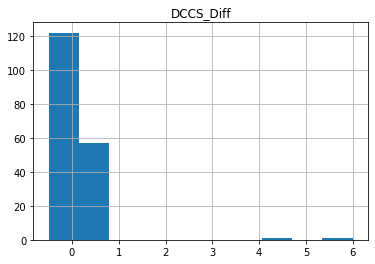

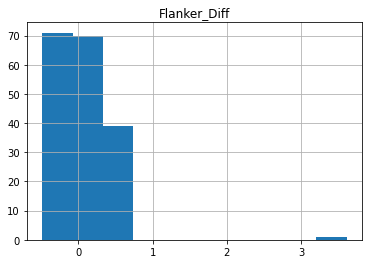

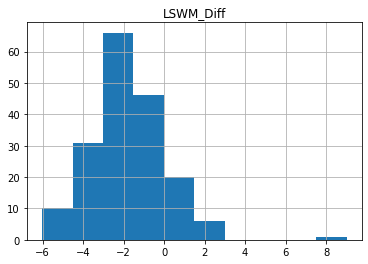

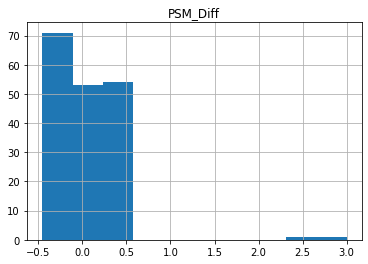

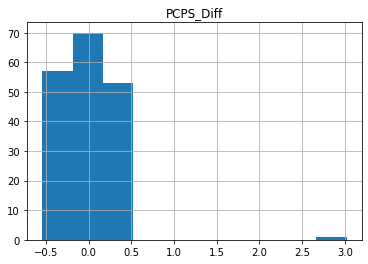

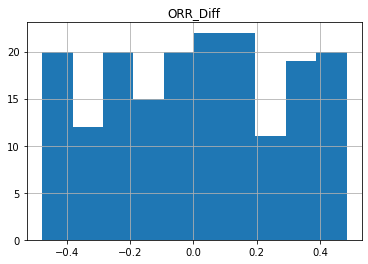

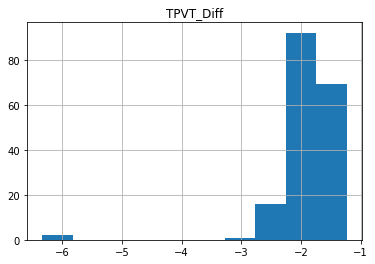

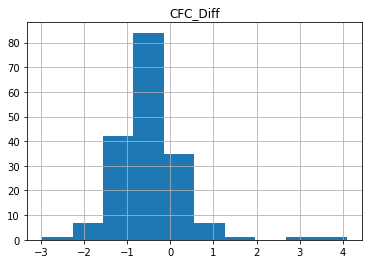

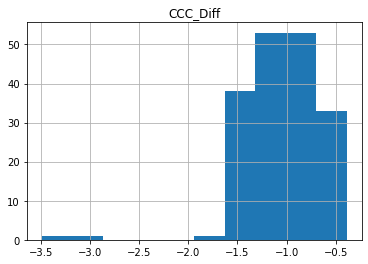

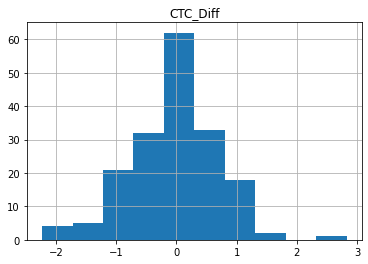

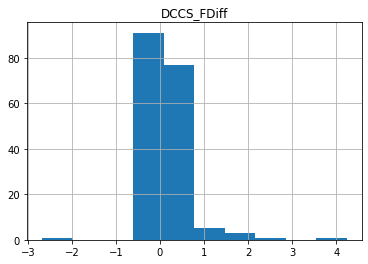

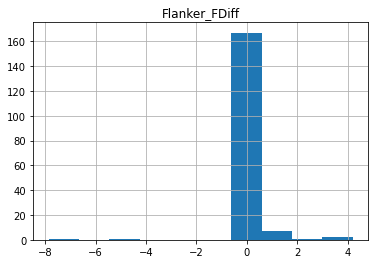

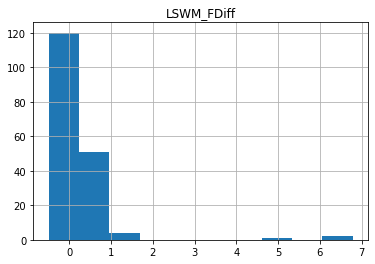

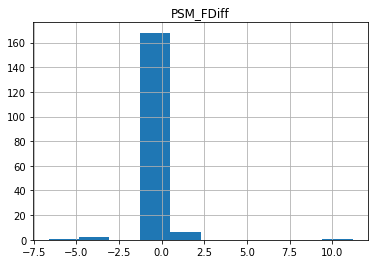

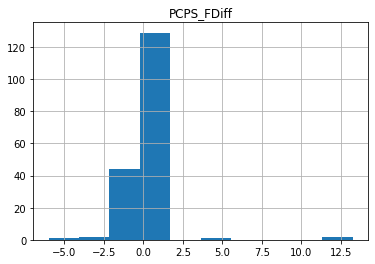

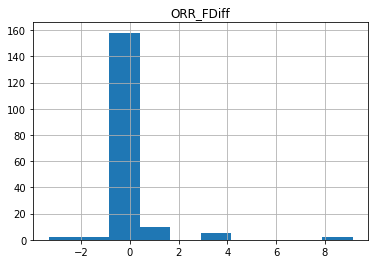

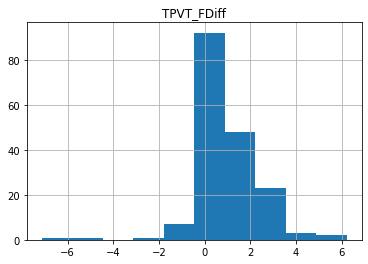

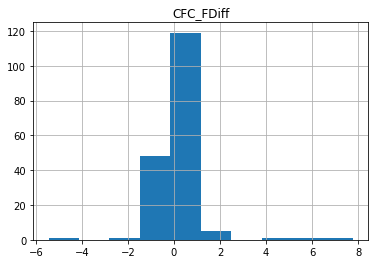

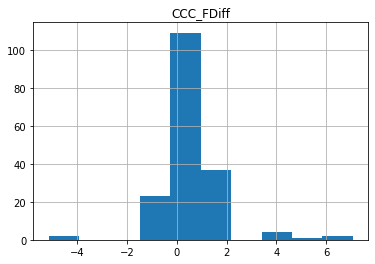

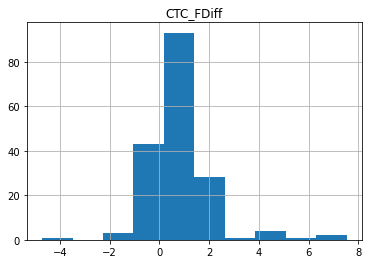

In [245]:
for diff in cd:
    genpop.hist(column=diff)

In [246]:
# calculate the Cohen's d between two samples
from numpy.random import randn
from numpy.random import seed
from numpy import mean
from numpy import var
from math import sqrt
 
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


In [247]:
#Formula from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5133225/

def CI95(d1, d2, cohend):
    
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    
    ss = (n1+n2)/(n1*n2) + (cohend)*(cohend)/(2*n1+2*n2)
    s = sqrt(ss)
    ci1  = round((cohend-1.96*s),2)
    ci2  = round((cohend+1.96*s),2)
    
    CI = '['+str(ci1) + ', ' + str(ci2)+']'
    return CI
    

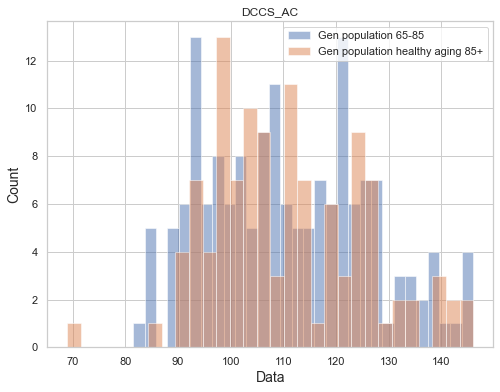

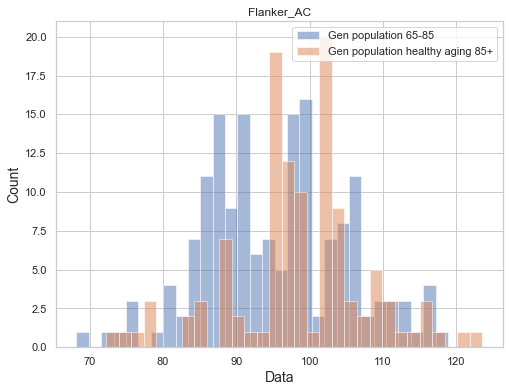

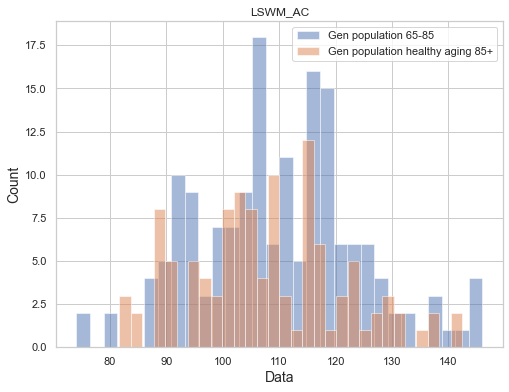

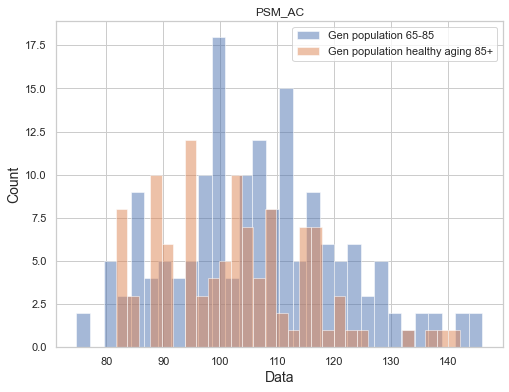

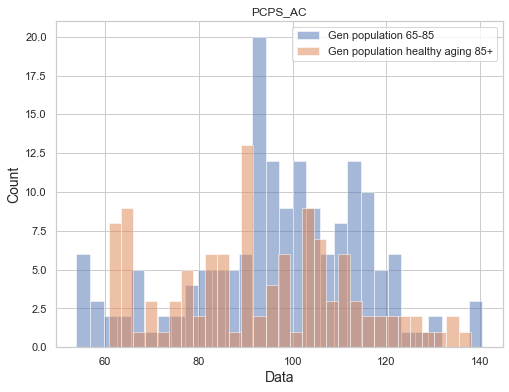

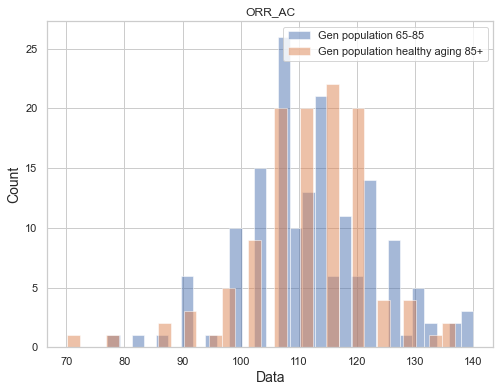

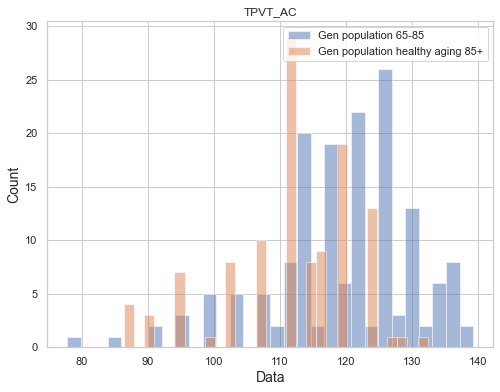

In [248]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

for col in measures:
    AC = col+'_AC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85']
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+']
    plt.figure(figsize=(8,6))
    plt.hist(g1[AC], bins=30, alpha=0.5, label='Gen population 65-85')
    plt.hist(g2[AC], bins=30, alpha=0.5, label= 'Gen population healthy aging 85+')
    plt.xlabel('Data', size=14)
    plt.ylabel('Count', size=14)
    plt.title(AC)
    plt.legend(loc='upper right')

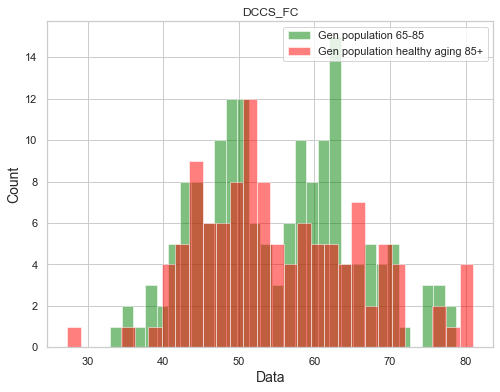

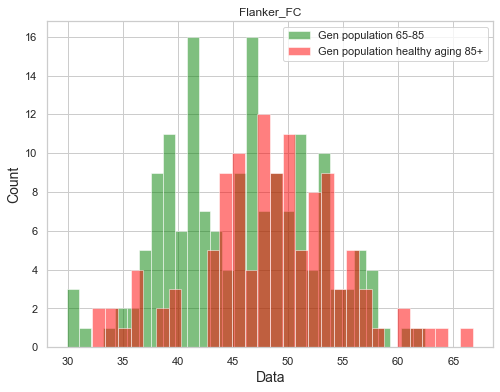

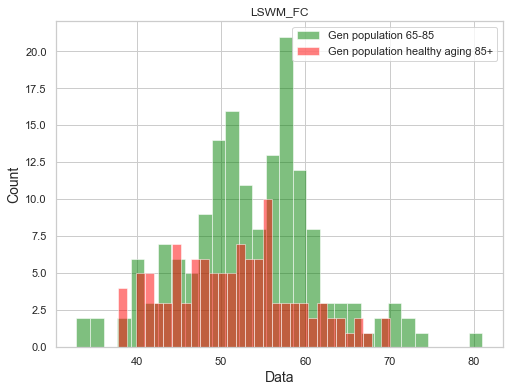

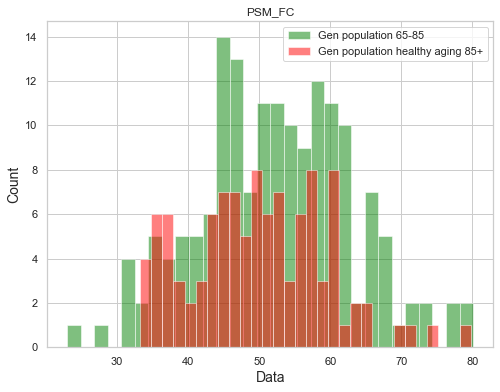

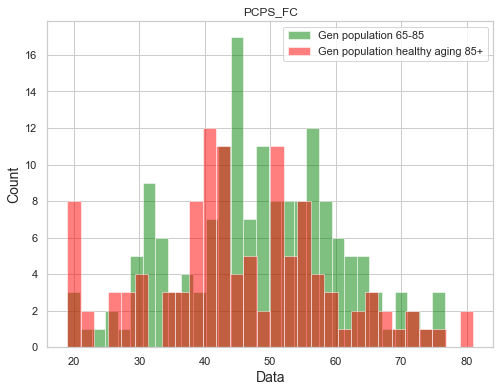

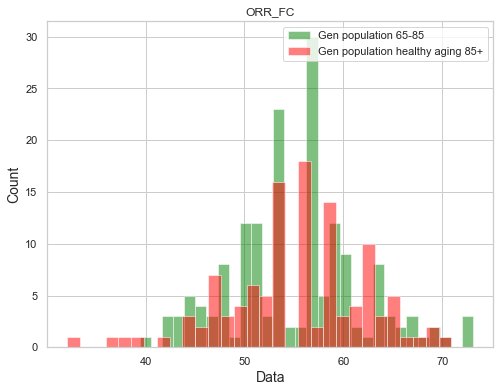

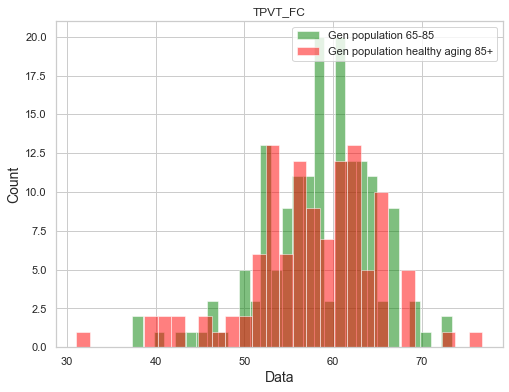

In [249]:
for col in measures:
    FC = col+'_FC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85']
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+']
    plt.figure(figsize=(8,6))
    plt.hist(g1[FC], bins=30, alpha=0.5, label='Gen population 65-85' , color='green')
    plt.hist(g2[FC], bins=30, alpha=0.5, label= 'Gen population healthy aging 85+', color='red')
    plt.xlabel('Data', size=14)
    plt.ylabel('Count', size=14)
    plt.title(FC)
    plt.legend(loc='upper right')

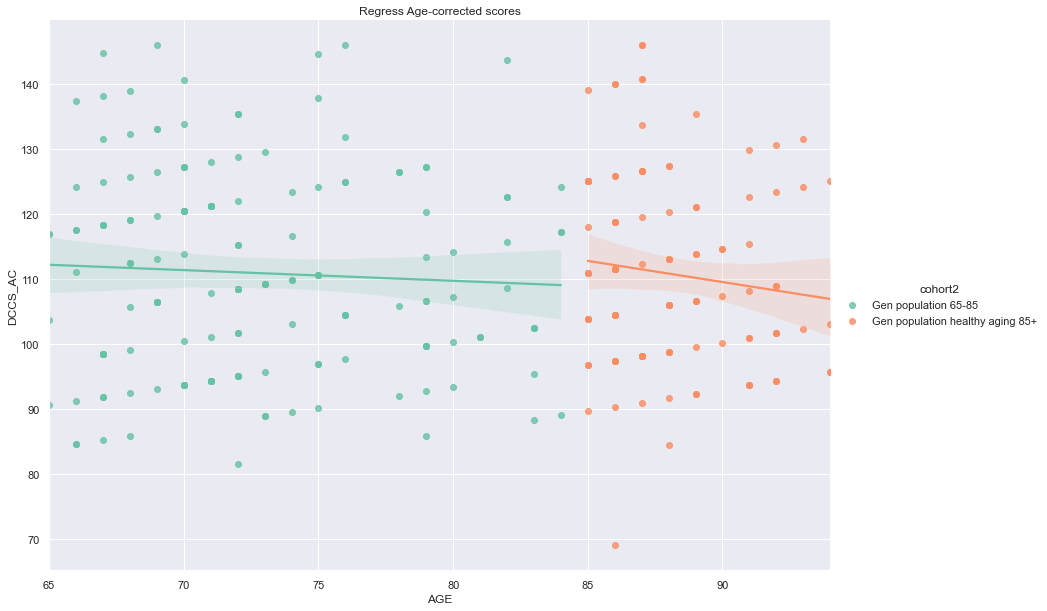

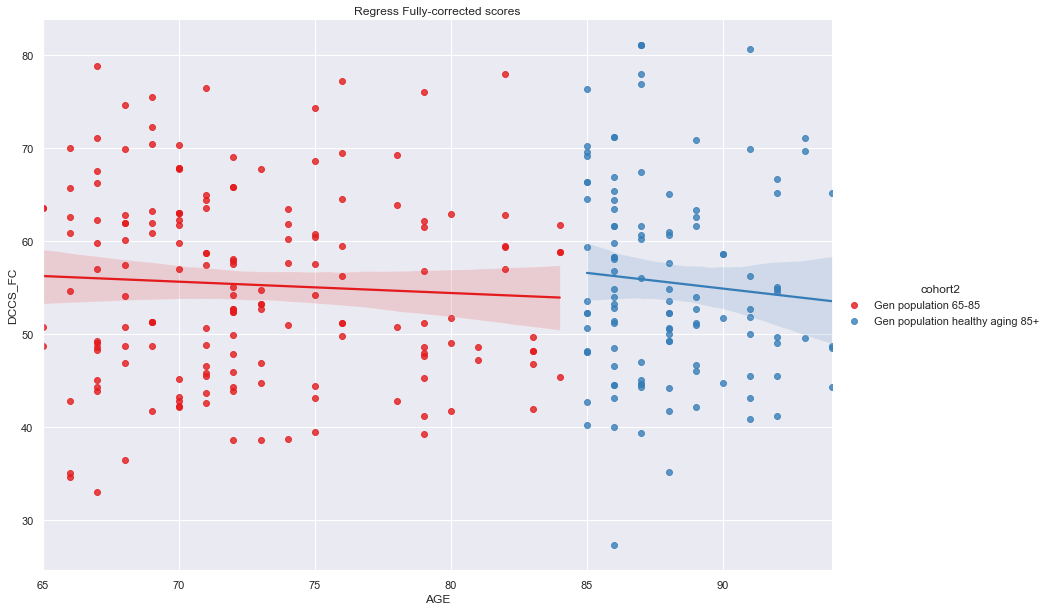

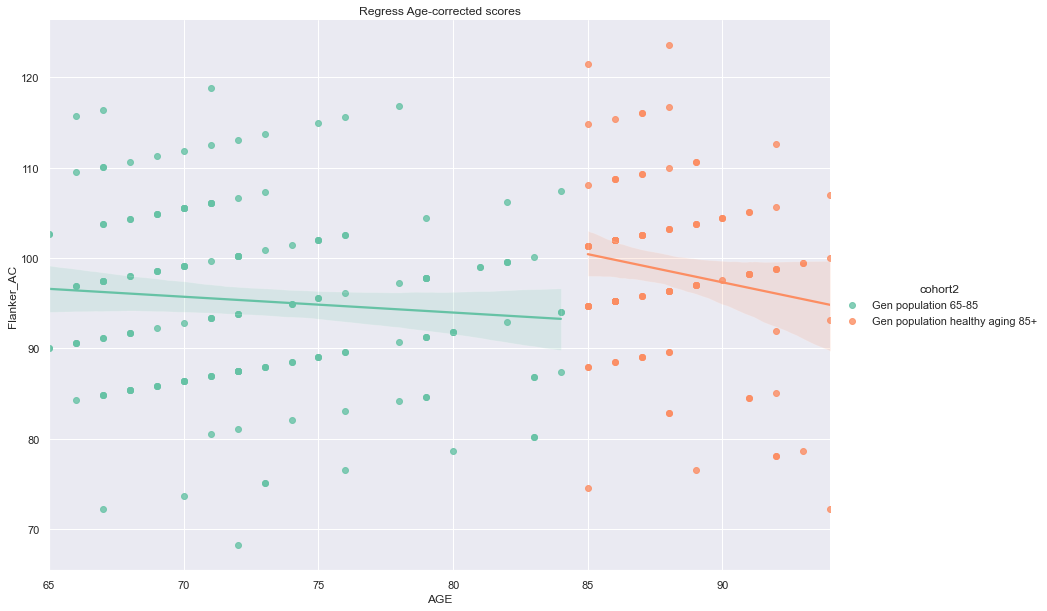

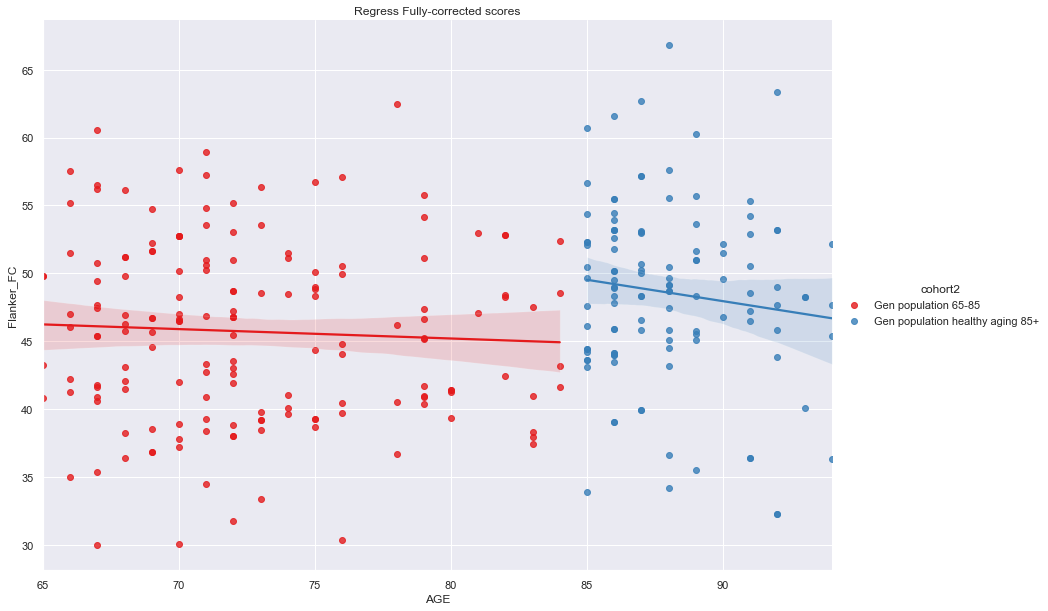

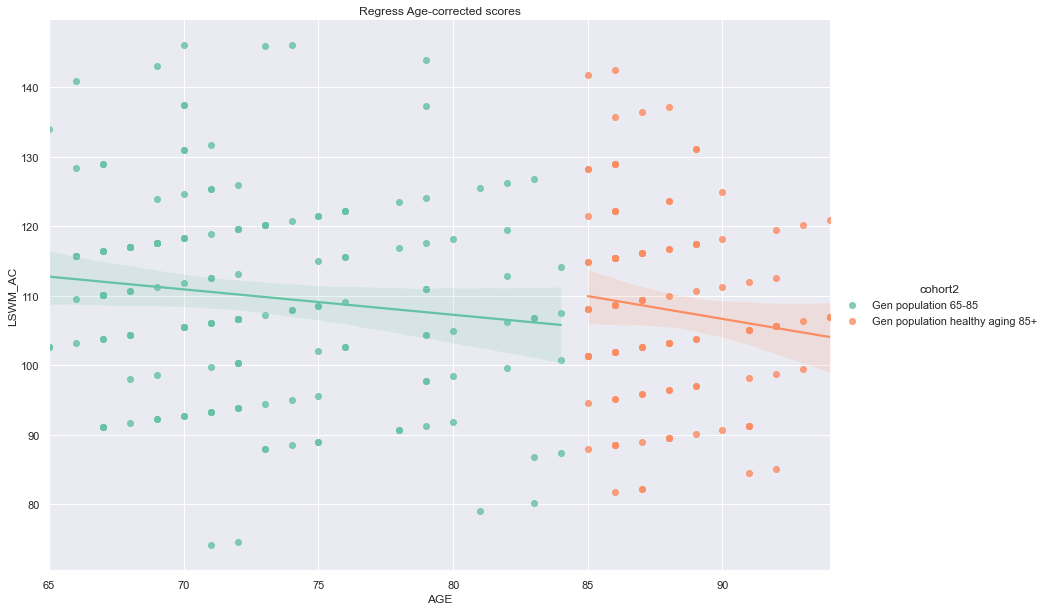

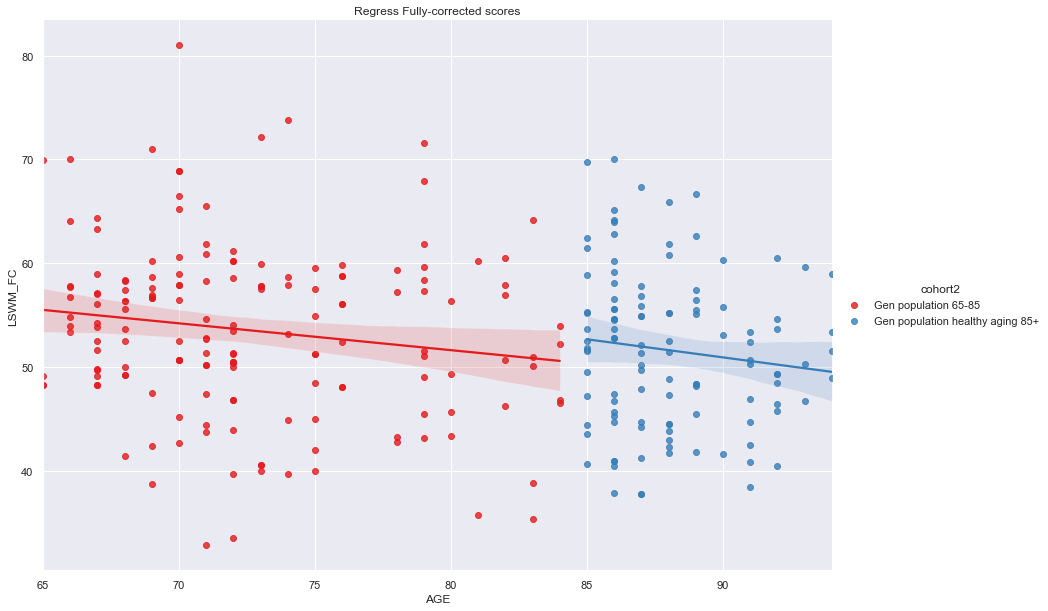

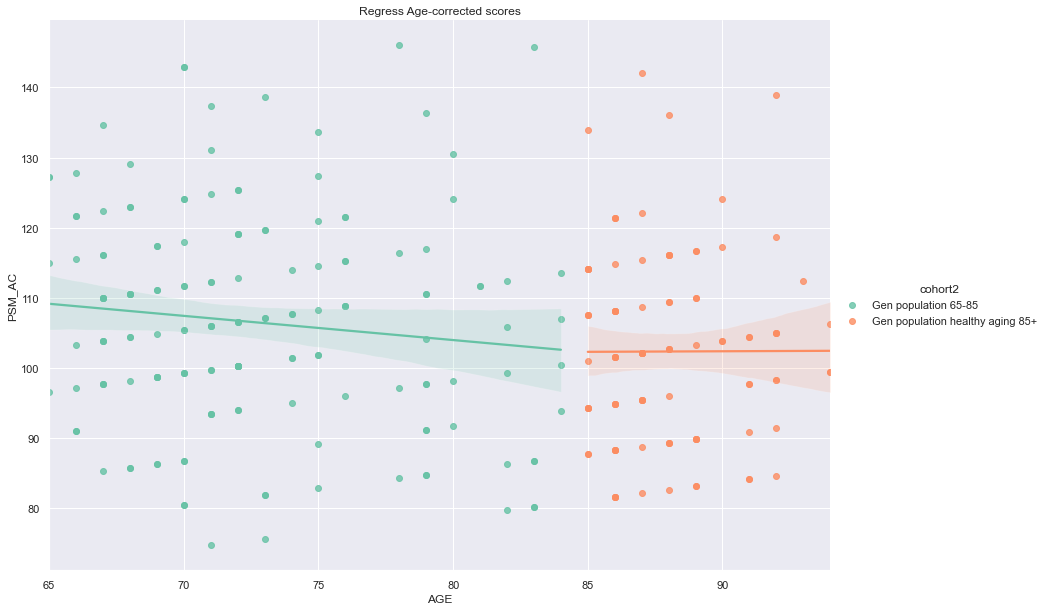

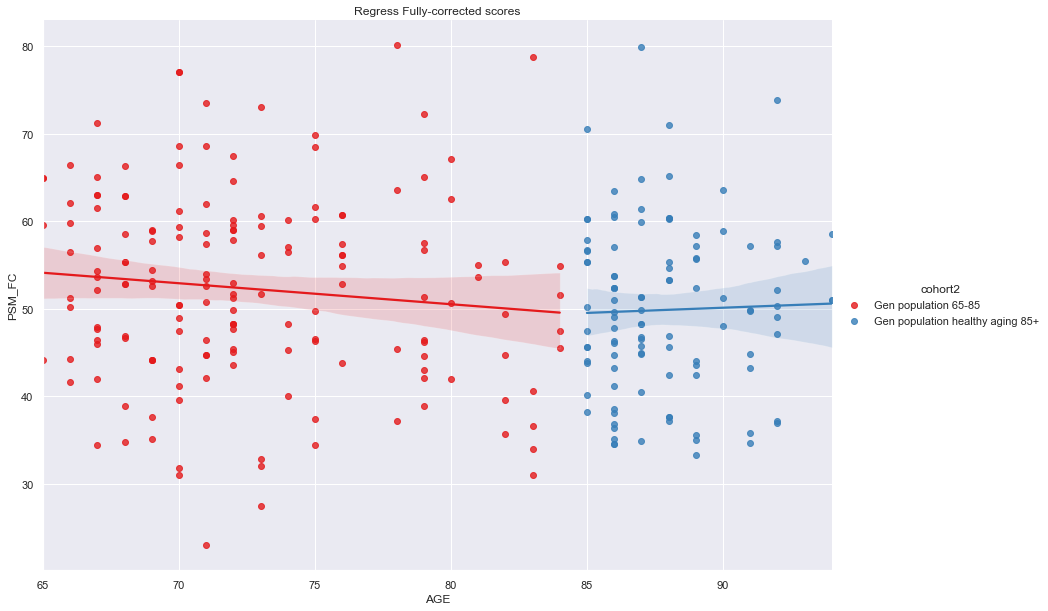

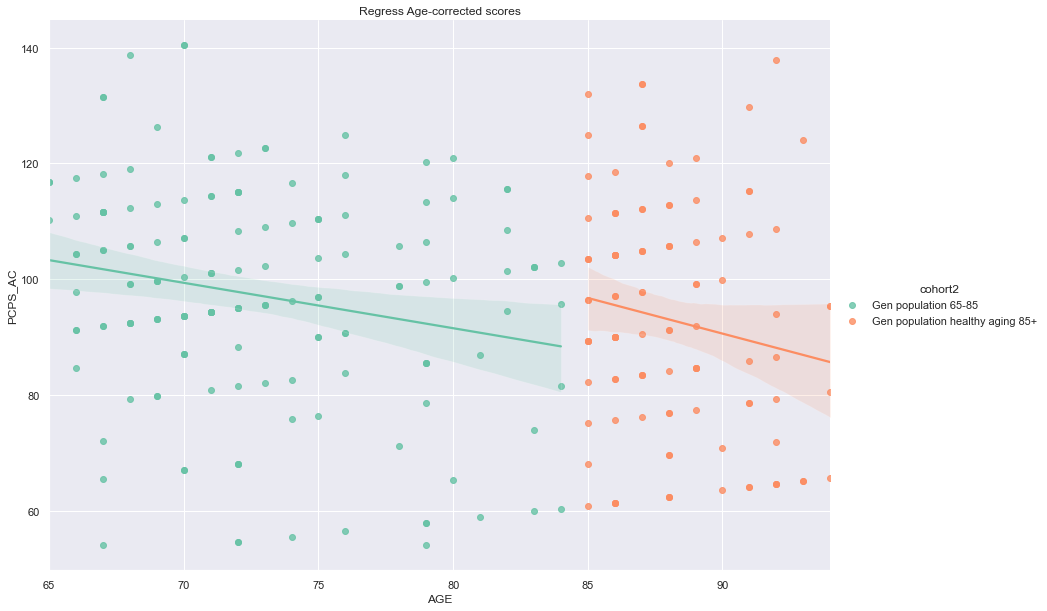

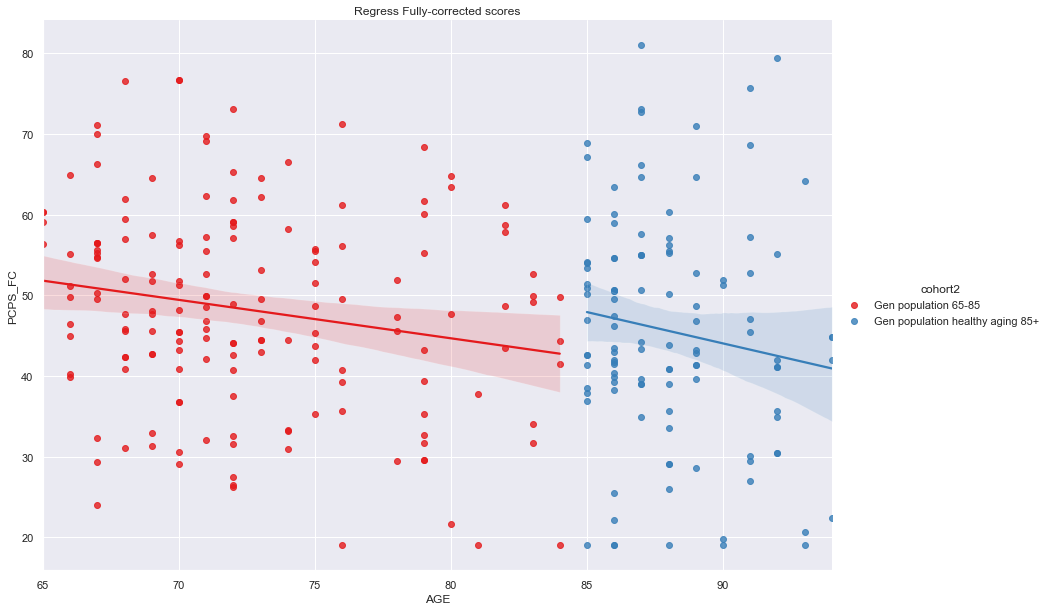

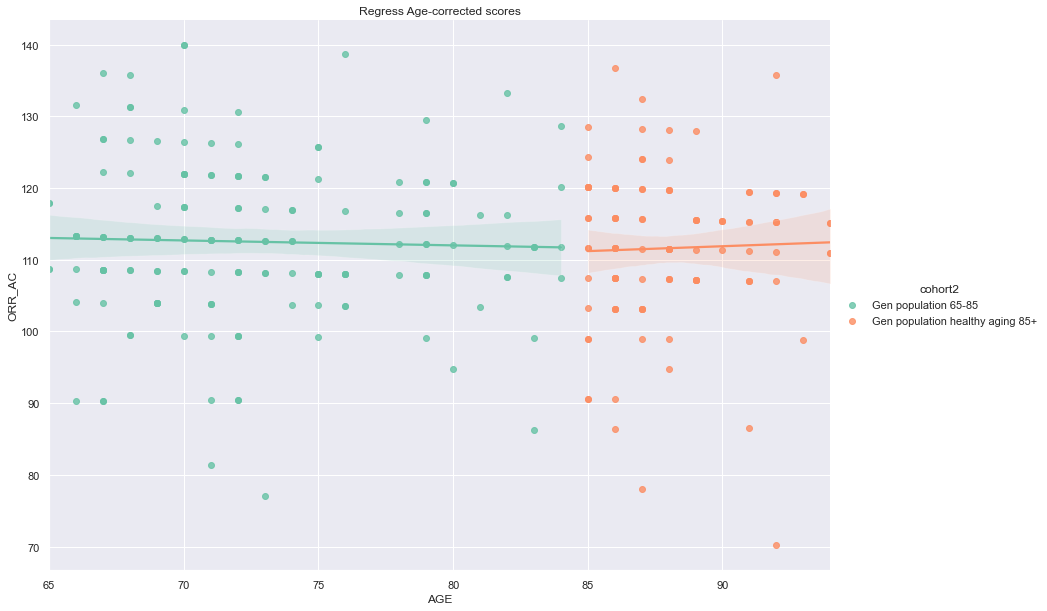

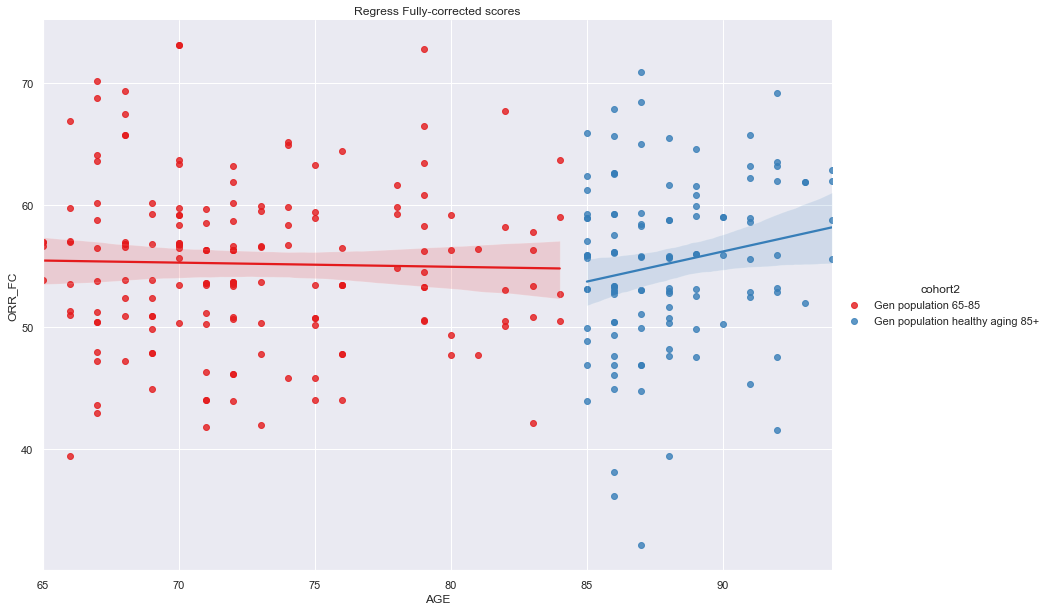

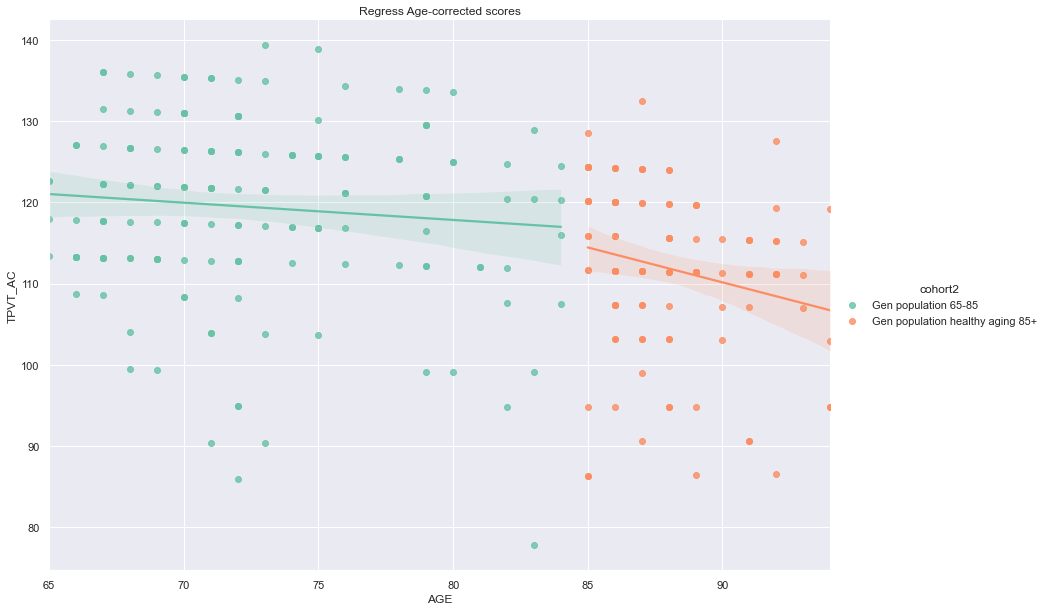

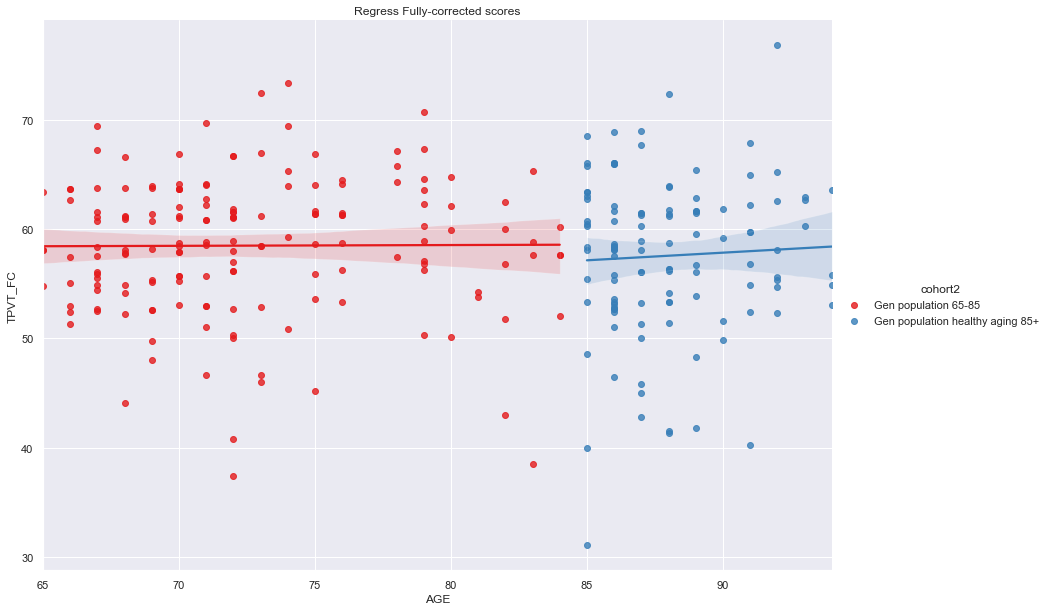

In [250]:
sns.set(style="darkgrid")
for col in measures:

    AC = col+'_AC'
    g = sns.lmplot(x="AGE", y=AC,hue="cohort2", data=genpop, palette="Set2",height=8.27, aspect=11.7/8.27)
    plt.title('Regress Age-corrected scores')

    FC = col+'_FC'
    g = sns.lmplot(x="AGE", y=FC,hue="cohort2", data=genpop, palette="Set1",height=8.27, aspect=11.7/8.27)
    plt.title('Regress Fully-corrected scores')

In [251]:
import numpy as np
import scipy.stats as stats
print("Aged-corrected")
for col in measures:
    AC = col+'_AC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85'][AC]
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+'][AC]
    print(col, 't-stat = %6.2f, pvalue = %6.2f' % stats.ttest_ind(g1.dropna(), g2.dropna(), equal_var=False))
    d = cohend(g1, g2)
    print('Cohens d: %.3f (' % d,'Gen population 65-85 vs Gen population healthy aging 85+', ")")

Aged-corrected
DCCS t-stat =   0.06, pvalue =   0.95
Cohens d: 0.007 ( Gen population 65-85 vs Gen population healthy aging 85+ )
Flanker t-stat =  -2.83, pvalue =   0.01
Cohens d: -0.341 ( Gen population 65-85 vs Gen population healthy aging 85+ )
LSWM t-stat =   1.17, pvalue =   0.24
Cohens d: 0.142 ( Gen population 65-85 vs Gen population healthy aging 85+ )
PSM t-stat =   2.41, pvalue =   0.02
Cohens d: 0.292 ( Gen population 65-85 vs Gen population healthy aging 85+ )
PCPS t-stat =   1.83, pvalue =   0.07
Cohens d: 0.225 ( Gen population 65-85 vs Gen population healthy aging 85+ )
ORR t-stat =   0.69, pvalue =   0.49
Cohens d: 0.083 ( Gen population 65-85 vs Gen population healthy aging 85+ )
TPVT t-stat =   5.92, pvalue =   0.00
Cohens d: 0.711 ( Gen population 65-85 vs Gen population healthy aging 85+ )


Small Effect Size: d=0.20
Medium Effect Size: d=0.50
Large Effect Size: d=0.80

In [252]:
print("Fully-corrected")
for col in measures:
    FC = col+'_FC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85'][FC]
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+'][FC]
    print(col, 't-stat = %6.2f, pvalue = %6.2f' % stats.ttest_ind(g1.dropna(), g2.dropna(), equal_var=False))
    # calculate cohen's d
    d = cohend(g1, g2)
    print('Cohens d: %.3f (' % d,'Gen population 65-85 vs Gen population healthy aging 85+', ")")
    print('')

Fully-corrected
DCCS t-stat =  -0.19, pvalue =   0.85
Cohens d: -0.024 ( Gen population 65-85 vs Gen population healthy aging 85+ )

Flanker t-stat =  -3.59, pvalue =   0.00
Cohens d: -0.437 ( Gen population 65-85 vs Gen population healthy aging 85+ )

LSWM t-stat =   2.00, pvalue =   0.05
Cohens d: 0.241 ( Gen population 65-85 vs Gen population healthy aging 85+ )

PSM t-stat =   1.93, pvalue =   0.05
Cohens d: 0.234 ( Gen population 65-85 vs Gen population healthy aging 85+ )

PCPS t-stat =   1.59, pvalue =   0.11
Cohens d: 0.199 ( Gen population 65-85 vs Gen population healthy aging 85+ )

ORR t-stat =  -0.03, pvalue =   0.97
Cohens d: -0.004 ( Gen population 65-85 vs Gen population healthy aging 85+ )

TPVT t-stat =   1.10, pvalue =   0.27
Cohens d: 0.138 ( Gen population 65-85 vs Gen population healthy aging 85+ )



In [253]:
genpop[select].round(2).to_csv('C:/Users/tsb7592/Downloads/age_corrected_data.csv', index=False)

In [254]:
genpop[genpop.AGE <= 85][['AGE','MALE','EDUCATION']].describe()

,AGE,MALE,EDUCATION
count,181.00,181.00,181.00
mean,73.80,0.34,16.96
std,6.03,0.48,2.14
min,65.00,0.00,8.00
25%,69.00,0.00,16.00
50%,72.00,0.00,18.00
75%,79.00,1.00,18.00
max,85.00,1.00,20.00


In [255]:
genpop[genpop.AGE<= 85]['MARISTAT'].value_counts()

Married                                      57
Divorced                                     25
Widowed                                      20
Never married (or marriage was annulled)      3
Living as married/domestic partner            2
Name: MARISTAT, dtype: int64

In [256]:
# for the below 85 group and above 85 group: age (mean and sd), education level, race/ethnicity, gender, marital status

genpop[genpop.AGE > 85][['AGE','MALE','EDUCATION']].describe()

,AGE,MALE,EDUCATION
count,99.00,99.00,99.00
mean,88.57,0.48,16.45
std,2.41,0.50,2.93
min,86.00,0.00,7.00
25%,86.00,0.00,16.00
50%,88.00,0.00,16.00
75%,91.00,1.00,18.00
max,94.00,1.00,20.00


In [257]:
genpop[genpop.AGE> 85]['MARISTAT'].value_counts()

Married                                      20
Widowed                                      14
Divorced                                      5
Never married (or marriage was annulled)      5
Name: MARISTAT, dtype: int64

In [258]:
genpop.columns

Index(['ptid', 'assmnt', 'site', 'cohort2', 'LANGUAGE', 'AGE', 'gender_rc',
       'ethnicity_rc', 'race_tb_rc', 'racetb_w',
       ...
       'ORR_AC', 'ORR_Diff', 'TPVT_AC', 'TPVT_Diff', 'CFC_AC', 'CFC_Diff',
       'CCC_AC', 'CCC_Diff', 'CTC_AC', 'CTC_Diff'],
      dtype='object', length=246)

In [259]:
genpop[genpop.AGE> 85]['race'].value_counts()

White                        90
Black or African American     8
Asian                         1
Name: race, dtype: int64

In [260]:
genpop.EDUCATION.describe()

count   280.00
mean     16.78
std       2.46
min       7.00
25%      16.00
50%      18.00
75%      18.00
max      20.00
Name: EDUCATION, dtype: float64

In [261]:
table = pd.DataFrame(columns=('<85', '>=85'))

for col in genpop.columns:
    if 'UCS' in col:
        avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
        st = round(genpop[genpop.AGE<85][col].std(), 2)
        val = str(avg) + '('+str(st)+')'
        avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
        st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
        val1 = str(avg1) + '('+str(st1)+')'
        ind = col.split('_')[0]
        table.loc[ind] = [val, val1]

In [262]:
table

,<85,>=85
CCC,116.75(7.22),114.06(6.88)
CFC,92.7(10.19),82.5(9.68)
CTC,104.99(8.36),97.85(7.67)
DCCS,100.21(7.78),93.24(11.05)
Flanker,93.36(7.44),89.78(8.45)
LSWM,98.53(10.55),90.6(10.32)
ORR,111.8(5.45),111.94(6.02)
PCPS,87.05(14.12),77.07(13.4)
PSM,99.12(13.31),88.5(9.64)
TPVT,120.27(9.12),115.18(8.35)


In [263]:
ACcol= ['DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC']

In [264]:
table1 = pd.DataFrame(columns=('<85_AC', '>=85_AC'))

for col in ACcol:
    avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
    st = round(genpop[genpop.AGE<85][col].std(), 2)
    val = str(avg) + '('+str(st)+')'
    avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
    st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
    val1 = str(avg1) + '('+str(st1)+')'
    ind = col.split('_')[0]
    table1.loc[ind] = [val, val1]

In [265]:
table1

,<85_AC,>=85_AC
DCCS,110.93(15.28),110.82(14.47)
Flanker,95.25(9.85),98.54(9.34)
LSWM,109.95(14.39),107.95(13.65)
PSM,106.53(15.1),102.36(13.09)
PCPS,97.29(18.55),93.01(19.71)
ORR,112.52(10.91),111.63(10.51)
TPVT,119.4(10.95),111.88(10.02)
CFC,105.71(14.27),104.46(13.59)
CCC,117.36(11.12),112.61(10.04)
CTC,112.49(11.3),109.75(10.12)


In [266]:
FCcol =['DCCS_FC',
'Flanker_FC',
'LSWM_FC',
'PSM_FC',
'PCPS_FC',
'ORR_FC',
'TPVT_FC',
'CFC_FC',
'CCC_FC',
'CTC_FC']

In [267]:
table2 = pd.DataFrame(columns=('<85_FC', '>=85_FC'))

for col in FCcol:
    avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
    st = round(genpop[genpop.AGE<85][col].std(), 2)
    val = str(avg) + '('+str(st)+')'
    avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
    st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
    val1 = str(avg1) + '('+str(st1)+')'
    ind = col.split('_')[0]
    table2.loc[ind] = [val, val1]

In [268]:
table2

,<85_FC,>=85_FC
DCCS,55.28(10.17),55.53(10.78)
Flanker,45.7(6.58),48.57(6.5)
LSWM,53.53(8.23),51.61(7.53)
PSM,52.28(10.89),49.86(9.51)
PCPS,48.17(12.44),45.56(14.07)
ORR,55.19(6.65),55.21(7.04)
TPVT,58.49(6.23),57.56(7.3)
CFC,51.32(9.11),50.71(9.37)
CCC,57.51(6.35),56.99(6.94)
CTC,54.83(6.43),54.54(6.92)


In [269]:
af = pd.merge(table1, table2, left_index=True, right_index=True)

In [270]:
rv = pd.merge(table, af, left_index=True, right_index=True)
rv

,<85,>=85,<85_AC,>=85_AC,<85_FC,>=85_FC
CCC,116.75(7.22),114.06(6.88),117.36(11.12),112.61(10.04),57.51(6.35),56.99(6.94)
CFC,92.7(10.19),82.5(9.68),105.71(14.27),104.46(13.59),51.32(9.11),50.71(9.37)
CTC,104.99(8.36),97.85(7.67),112.49(11.3),109.75(10.12),54.83(6.43),54.54(6.92)
DCCS,100.21(7.78),93.24(11.05),110.93(15.28),110.82(14.47),55.28(10.17),55.53(10.78)
Flanker,93.36(7.44),89.78(8.45),95.25(9.85),98.54(9.34),45.7(6.58),48.57(6.5)
LSWM,98.53(10.55),90.6(10.32),109.95(14.39),107.95(13.65),53.53(8.23),51.61(7.53)
ORR,111.8(5.45),111.94(6.02),112.52(10.91),111.63(10.51),55.19(6.65),55.21(7.04)
PCPS,87.05(14.12),77.07(13.4),97.29(18.55),93.01(19.71),48.17(12.44),45.56(14.07)
PSM,99.12(13.31),88.5(9.64),106.53(15.1),102.36(13.09),52.28(10.89),49.86(9.51)
TPVT,120.27(9.12),115.18(8.35),119.4(10.95),111.88(10.02),58.49(6.23),57.56(7.3)


In [271]:
rv.to_csv('C:/Users/tsb7592/Downloads/Table_2.csv')

In [272]:
abs(genpop['LSWM_FDiff']).value_counts(bins=[0, 0.01, 0.02,100])

(0.02, 100.0]     173
(0.01, 0.02]        3
(-0.001, 0.01]      2
Name: LSWM_FDiff, dtype: int64

In [273]:
data =genpop[genpop['LSWM_FDiff'].notnull()]['LSWM_FDiff']
data

13    -0.48
17     0.32
64     0.26
65    -0.35
67    -0.38
       ... 
824    0.22
825   -0.38
829   -0.03
834    0.13
836   -0.30
Name: LSWM_FDiff, Length: 178, dtype: float64

In [274]:
data.abs().value_counts(bins=[0, 0.01, 0.02,100], normalize=True)

(0.02, 100.0]    0.97
(0.01, 0.02]     0.02
(-0.001, 0.01]   0.01
Name: LSWM_FDiff, dtype: float64

In [275]:
genpop['CTC_FDiff'].value_counts(bins=[-100,-0.02,-0.01, 0.01, 0.02,100])

(0.02, 100.0]        140
(-100.001, -0.02]     34
(-0.01, 0.01]          1
(0.01, 0.02]           1
(-0.02, -0.01]         0
Name: CTC_FDiff, dtype: int64

In [276]:
N =[]
avg = []
for diff in cd:
    data = genpop[genpop[diff].notnull()][diff]
    N.append(data.shape[0])
    avg.append(round(data.mean(),2))
    row = data.abs().value_counts(bins=[0, 1, 2,100], normalize=True).to_frame()
    display(row)
    if diff !='DCCS_Diff':
        dat =dat.join(row)
    else:
        dat= row
        
dat.loc['Average Diff'] = avg
dat.loc['N'] = N

,DCCS_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,Flanker_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,LSWM_Diff
"(2.0, 100.0]",0.52
"(-0.001, 1.0]",0.27
"(1.0, 2.0]",0.21


,PSM_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,PCPS_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,ORR_Diff
"(-0.001, 1.0]",1.00
"(1.0, 2.0]",0.00
"(2.0, 100.0]",0.00


,TPVT_Diff
"(1.0, 2.0]",0.69
"(2.0, 100.0]",0.31
"(-0.001, 1.0]",0.00


,CFC_Diff
"(-0.001, 1.0]",0.74
"(1.0, 2.0]",0.24
"(2.0, 100.0]",0.02


,CCC_Diff
"(1.0, 2.0]",0.51
"(-0.001, 1.0]",0.48
"(2.0, 100.0]",0.01


,CTC_Diff
"(-0.001, 1.0]",0.87
"(1.0, 2.0]",0.11
"(2.0, 100.0]",0.02


,DCCS_FDiff
"(-0.001, 1.0]",0.94
"(1.0, 2.0]",0.04
"(2.0, 100.0]",0.02


,Flanker_FDiff
"(-0.001, 1.0]",0.95
"(2.0, 100.0]",0.03
"(1.0, 2.0]",0.02


,LSWM_FDiff
"(-0.001, 1.0]",0.97
"(1.0, 2.0]",0.02
"(2.0, 100.0]",0.02


,PSM_FDiff
"(-0.001, 1.0]",0.94
"(1.0, 2.0]",0.03
"(2.0, 100.0]",0.02


,PCPS_FDiff
"(-0.001, 1.0]",0.96
"(2.0, 100.0]",0.03
"(1.0, 2.0]",0.01


,ORR_FDiff
"(-0.001, 1.0]",0.93
"(2.0, 100.0]",0.05
"(1.0, 2.0]",0.02


,TPVT_FDiff
"(-0.001, 1.0]",0.57
"(1.0, 2.0]",0.25
"(2.0, 100.0]",0.19


,CFC_FDiff
"(-0.001, 1.0]",0.93
"(1.0, 2.0]",0.03
"(2.0, 100.0]",0.03


,CCC_FDiff
"(-0.001, 1.0]",0.74
"(1.0, 2.0]",0.20
"(2.0, 100.0]",0.06


,CTC_FDiff
"(-0.001, 1.0]",0.65
"(1.0, 2.0]",0.27
"(2.0, 100.0]",0.08


In [277]:
dat.head()

,DCCS_Diff,Flanker_Diff,LSWM_Diff,PSM_Diff,PCPS_Diff,ORR_Diff,TPVT_Diff,CFC_Diff,CCC_Diff,CTC_Diff,DCCS_FDiff,Flanker_FDiff,LSWM_FDiff,PSM_FDiff,PCPS_FDiff,ORR_FDiff,TPVT_FDiff,CFC_FDiff,CCC_FDiff,CTC_FDiff
"(-0.001, 1.0]",0.99,0.99,0.27,0.99,0.99,1.00,0.00,0.74,0.48,0.87,0.94,0.95,0.97,0.94,0.96,0.93,0.57,0.93,0.74,0.65
"(2.0, 100.0]",0.01,0.01,0.52,0.01,0.01,0.00,0.31,0.02,0.01,0.02,0.02,0.03,0.02,0.02,0.03,0.05,0.19,0.03,0.06,0.08
"(1.0, 2.0]",0.00,0.00,0.21,0.00,0.00,0.00,0.69,0.24,0.51,0.11,0.04,0.02,0.02,0.03,0.01,0.02,0.25,0.03,0.20,0.27
Average Diff,0.02,0.04,-1.73,0.06,0.01,0.01,-1.88,-0.51,-1.04,-0.04,0.10,0.02,0.14,0.03,0.15,0.16,0.79,0.15,0.54,0.79
N,181.00,181.00,180.00,180.00,181.00,181.00,180.00,179.00,180.00,178.00,179.00,179.00,178.00,178.00,179.00,179.00,178.00,177.00,178.00,176.00


In [278]:
dat.index = ['+/- 1', 'above 2', '1-2 points','Average Diff', 'N']

In [279]:
dat

,DCCS_Diff,Flanker_Diff,LSWM_Diff,PSM_Diff,PCPS_Diff,ORR_Diff,TPVT_Diff,CFC_Diff,CCC_Diff,CTC_Diff,DCCS_FDiff,Flanker_FDiff,LSWM_FDiff,PSM_FDiff,PCPS_FDiff,ORR_FDiff,TPVT_FDiff,CFC_FDiff,CCC_FDiff,CTC_FDiff
+/- 1,0.99,0.99,0.27,0.99,0.99,1.00,0.00,0.74,0.48,0.87,0.94,0.95,0.97,0.94,0.96,0.93,0.57,0.93,0.74,0.65
above 2,0.01,0.01,0.52,0.01,0.01,0.00,0.31,0.02,0.01,0.02,0.02,0.03,0.02,0.02,0.03,0.05,0.19,0.03,0.06,0.08
1-2 points,0.00,0.00,0.21,0.00,0.00,0.00,0.69,0.24,0.51,0.11,0.04,0.02,0.02,0.03,0.01,0.02,0.25,0.03,0.20,0.27
Average Diff,0.02,0.04,-1.73,0.06,0.01,0.01,-1.88,-0.51,-1.04,-0.04,0.10,0.02,0.14,0.03,0.15,0.16,0.79,0.15,0.54,0.79
N,181.00,181.00,180.00,180.00,181.00,181.00,180.00,179.00,180.00,178.00,179.00,179.00,178.00,178.00,179.00,179.00,178.00,177.00,178.00,176.00


In [280]:
dat.to_csv('C:/Users/tsb7592/Downloads/Table_diff.csv')

# ANOVA

In [281]:
def get_list(li, element):
    list_of_numbers = []
    list_of_numbers.append(element)
    for tup in li:
        try:
            list_of_numbers.append(round(float(tup),2))
        except ValueError:
            pass
        
    del list_of_numbers[2]
    
    CI = '['+str(list_of_numbers[2]) + ', ' + str(list_of_numbers[3])+']'
    list_of_numbers = list_of_numbers[:2]
    list_of_numbers.append(CI)
    list_of_numbers.append(li[-1])
    
    
    return list_of_numbers

In [282]:
genpop[genpop.AGE<85].shape

(164, 246)

In [283]:
l1= genpop[genpop.cohort2=='Gen population 65-85']['DCCS_UCSScore'].dropna()
l2= genpop[genpop.cohort2=='Gen population healthy aging 85+']['DCCS_UCSScore'].dropna()

In [284]:
len(g1)

164

In [285]:
genpop.shape

(280, 246)

In [286]:
def tukey_test(df, var):
    df =df[['cohort', var]].dropna()
    tukey = pairwise_tukeyhsd(endog=df[var],
                          groups=df['cohort'],
                          alpha=0.05)

    return(tukey)

In [287]:
gg1 = genpop[genpop.cohort2=='Gen population 65-85']['DCCS_UCSScore'].dropna()

In [294]:
gg1.mean()

100.20731707317073

In [295]:
gg2.mean()

93.24347826086957

In [289]:
gg2 = genpop[genpop.cohort2!='Gen population 65-85']['DCCS_UCSScore'].dropna()
gg2

19    102.00
37     97.00
54     66.00
85     90.00
116    66.00
       ...  
663    99.00
664   108.00
757   103.00
770    95.00
823    91.00
Name: DCCS_UCSScore, Length: 115, dtype: float64

In [358]:
tstat

6.177637027414584

In [357]:
tstat, p = stats.ttest_ind(X1, X2)

In [361]:
def number(X1, X2):
    
    tstat, p = stats.ttest_ind(X1, X2)
    diff = X1.mean()-X2.mean()
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    a,b=cm.tconfint_diff(usevar='unequal')
    CI = '['+str(a)[:4]+', '+str(b)[:4]+']'
                 
    print('t-statistic = %6.2f pvalue = %6.2f' % stats.ttest_ind(X1, X2, equal_var = False))
    print("mean difference is %6.2f" % (X1.mean()-X2.mean()))
    print('95 CI=[%6.2f,%6.2f]' %cm.tconfint_diff(usevar='unequal'))
                 
    return round(tstat,2), round(diff,2), CI

In [360]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np, statsmodels.stats.api as sms

def all_stat(data, col):
    UCS = col+'_UCSScore'
    AC = col+'_AC'
    ACSS = col+'_ACSScore'
    FC = col+'_FC'
    FCTS= col+'_FCTScore'
    
    g1 = data[data.cohort2=='Gen population 65-85'][UCS].dropna()
    g2 = data[data.cohort2=='Gen population healthy aging 85+'][UCS].dropna()

    g3 = data[data.cohort2=='Gen population 65-85'][AC].dropna()
    g4 = data[data.cohort2=='Gen population healthy aging 85+'][AC].dropna()
    g5 = data[data.cohort2=='Gen population 65-85'][ACSS].dropna()
    
    g6 = data[data.cohort2=='Gen population 65-85'][FC].dropna()
    g7 = data[data.cohort2=='Gen population healthy aging 85+'][FC].dropna()
    g8 = data[data.cohort2=='Gen population 65-85'][FCTS].dropna()
    
    
    # calculate numbers
    t1, d1, c1= number(g1,g2)
    
    t2, d2, c2=number(g3, g4)
    
    t3, d3, c3 = number(g3, g5)
    
    t4, d4, c4 = number(g6, g7)
    
    t5, d5, c5 =number(g6, g8)
                                                
    coh = [[t1,t2,t3,t4,t5],[d1, d2, d3, d4, d5], [c1,c2,c3,c4,c5]]
    
    rdf = pd.DataFrame(coh,  index =[col+" tstat","mean diff", '95 CI' ],columns =['65-85 vs 85+','AC: 65-85 (derived) vs 85+ ','AC: 65-85 (given) vs 85+ ','FC: 65-85 (derived) vs 85+ ','FC: 65-85 (given) vs 85+ '], dtype = float)

    return rdf
    

In [353]:
allcol= ['DCCS',
 'Flanker',
 'LSWM',
 'PSM',
 'PCPS',
 'ORR',
 'TPVT',
 'CFC',
 'CCC',
 'CTC']

In [362]:
rv =[]
for col in allcol:
    rdf = all_stat(genpop, col)
    rv.append(rdf)
rv = pd.concat(rv)

t-statistic =   5.82 pvalue =   0.00
mean difference is   6.96
95 CI=[  4.60,  9.32]
t-statistic =   0.06 pvalue =   0.95
mean difference is   0.11
95 CI=[ -3.44,  3.66]
t-statistic =  -0.01 pvalue =   0.99
mean difference is  -0.01
95 CI=[ -3.34,  3.32]
t-statistic =  -0.19 pvalue =   0.85
mean difference is  -0.25
95 CI=[ -2.77,  2.27]
t-statistic =  -0.06 pvalue =   0.96
mean difference is  -0.06
95 CI=[ -2.28,  2.15]
t-statistic =   3.64 pvalue =   0.00
mean difference is   3.58
95 CI=[  1.64,  5.51]
t-statistic =  -2.83 pvalue =   0.01
mean difference is  -3.29
95 CI=[ -5.58, -1.00]
t-statistic =  -0.04 pvalue =   0.97
mean difference is  -0.04
95 CI=[ -2.18,  2.10]
t-statistic =  -3.59 pvalue =   0.00
mean difference is  -2.86
95 CI=[ -4.43, -1.29]
t-statistic =   0.03 pvalue =   0.97
mean difference is   0.02
95 CI=[ -1.42,  1.46]
t-statistic =   6.23 pvalue =   0.00
mean difference is   7.93
95 CI=[  5.42, 10.44]
t-statistic =   1.17 pvalue =   0.24
mean difference is   2.00
95

In [363]:
rv

,65-85 vs 85+,AC: 65-85 (derived) vs 85+,AC: 65-85 (given) vs 85+,FC: 65-85 (derived) vs 85+,FC: 65-85 (given) vs 85+
DCCS tstat,6.18,0.06,-0.01,-0.20,-0.06
mean diff,6.96,0.11,-0.01,-0.25,-0.06
95 CI,"[4.60, 9.32]","[-3.4, 3.65]","[-3.3, 3.31]","[-2.7, 2.27]","[-2.2, 2.15]"
Flanker tstat,3.73,-2.80,-0.04,-3.59,0.03
mean diff,3.58,-3.29,-0.04,-2.86,0.02
95 CI,"[1.64, 5.51]","[-5.5, -0.9]","[-2.1, 2.09]","[-4.4, -1.2]","[-1.4, 1.46]"
LSWM tstat,6.20,1.16,1.22,1.97,-0.23
mean diff,7.93,2.00,1.86,1.92,-0.21
95 CI,"[5.42, 10.4]","[-1.3, 5.36]","[-1.1, 4.85]","[0.03, 3.79]","[-1.9, 1.58]"
PSM tstat,7.12,2.34,-0.04,1.88,-0.00


In [364]:
rv.to_csv('C:/Users/tsb7592/Downloads/cohensd.csv')

In [ ]:
genpop[[]]